# Predicting the Presence of Diabetes Based on Health Metrics
### By: Alex Lee

## Introduction
Diabetes affects over 34 million Americans (Roughly 10.5% of the USA population) and of these 34 million, a little over 32 million were affected by Type II diabetes. Diabetes can affect individuals of all ages but its greatest prevalence is in seniors. 

Diabetes mellitus is a group of diseases that affects the body's use and regulation of blood glucose levels. Although the mechanisms may differ, individuals with diabetes often have an excess level of blood sugar, which can lead to a variety of different health problems. Type I diabetes is caused by genetic mutations leading to an inability to produce significant levels of insulin and can be treated with insulin injections and proper management. In contrast, Type II diabetes is usually developed over the course of a lifespan and is heavily influenced by diet and other risk factors. These risk factors include weight, inactivity, familial history, age, race, blood pressure and cholesterol levels. Individual's with type II diabetes often have reduced sensisitvity to insulin, a key regulator of blood glucose. 

In this project, I will attempt to create a logisitic regression model to predict whether or not an individual may have diabetes based on common health metrics. While this data set is missing some risk factors such as familial history and race as well as the type of diabetes, it still contains many potentially useful features to analyze. 

In [2]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

In [3]:
diabetes = pd.read_csv('diabetes.csv')

## Data Cleaning

In [3]:
diabetes = diabetes.set_index('patient_number')

In [4]:
diabetes['diabetes'].value_counts()

No diabetes    330
Diabetes        60
Name: diabetes, dtype: int64

In [5]:
diabetes['diabetes'] = diabetes['diabetes'].map({'No diabetes' : 0, 'Diabetes': 1})
#0 indicates no diabetes, 1 indicates yes diabetes
diabetes['gender'] = diabetes['gender'].map({'female' : 0, 'male': 1})

In [6]:
cols = ['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']
for col in cols:
    diabetes[col] = diabetes[col].str.replace(',', '.')
    diabetes[col] = diabetes[col].astype(float)

In [7]:
diabetes.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
patient_number,,,,,,,,,,,,,,,
1,193,77,49,3.9,19,0,61,119,22.5,118,70,32,38,0.84,0
2,146,79,41,3.6,19,0,60,135,26.4,108,58,33,40,0.83,0
3,217,75,54,4.0,20,0,67,187,29.3,110,72,40,45,0.89,0
4,226,97,70,3.2,20,0,64,114,19.6,122,64,31,39,0.79,0
5,164,91,67,2.4,20,0,70,141,20.2,122,86,32,39,0.82,0


## Feature Engineering

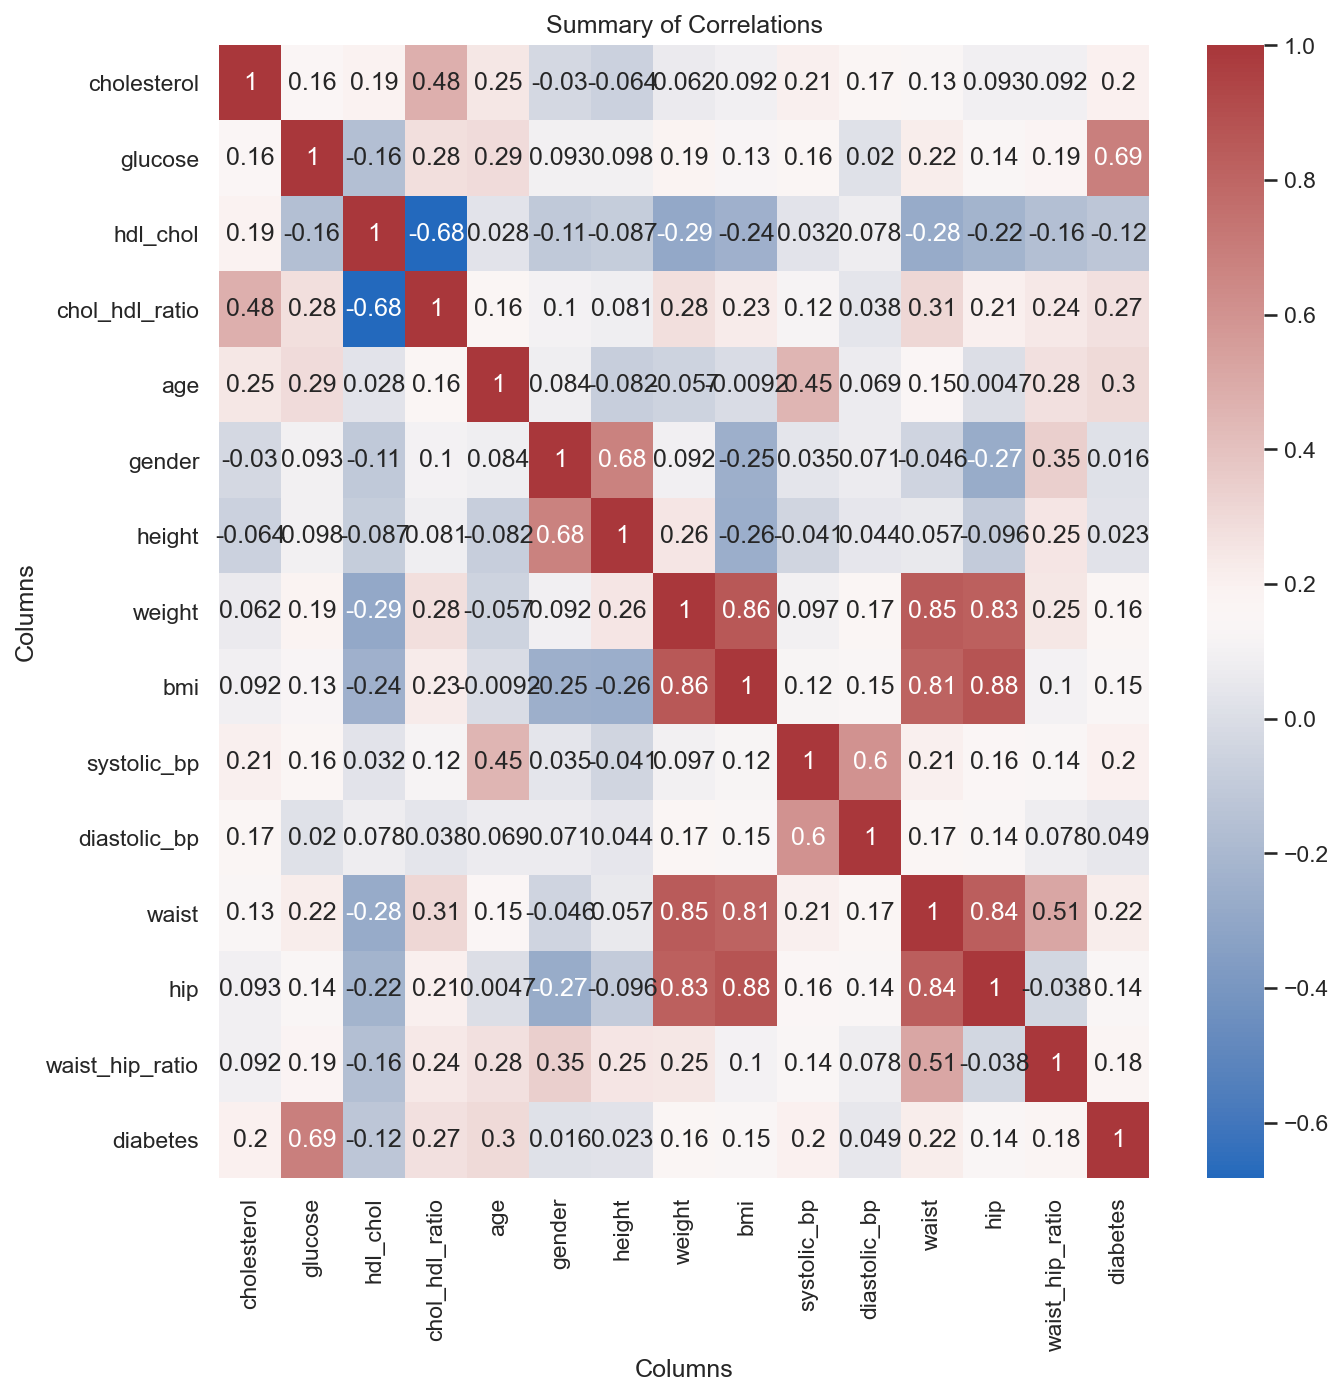

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(diabetes.corr(), annot = True, ax = ax, cmap = 'vlag')
plt.title('Summary of Correlations')
plt.xlabel('Columns')
plt.ylabel('Columns');

Based on this graph, we can see the correlation between each feature and the presence of diabetes (Looking at the bottom row or final column). As expected, glucose had the highest correlation (0.69). Other common risk factors such as the cholesterol to hdl ratio, age, and waist size showed a somewhat low correlation with none being higher than and absolute value of 0.3. It is important to note that this figure shows individual features and that a combination of some or all of these may be more useful. The following plots explore the densities of different features in individuals with and without diabetes.

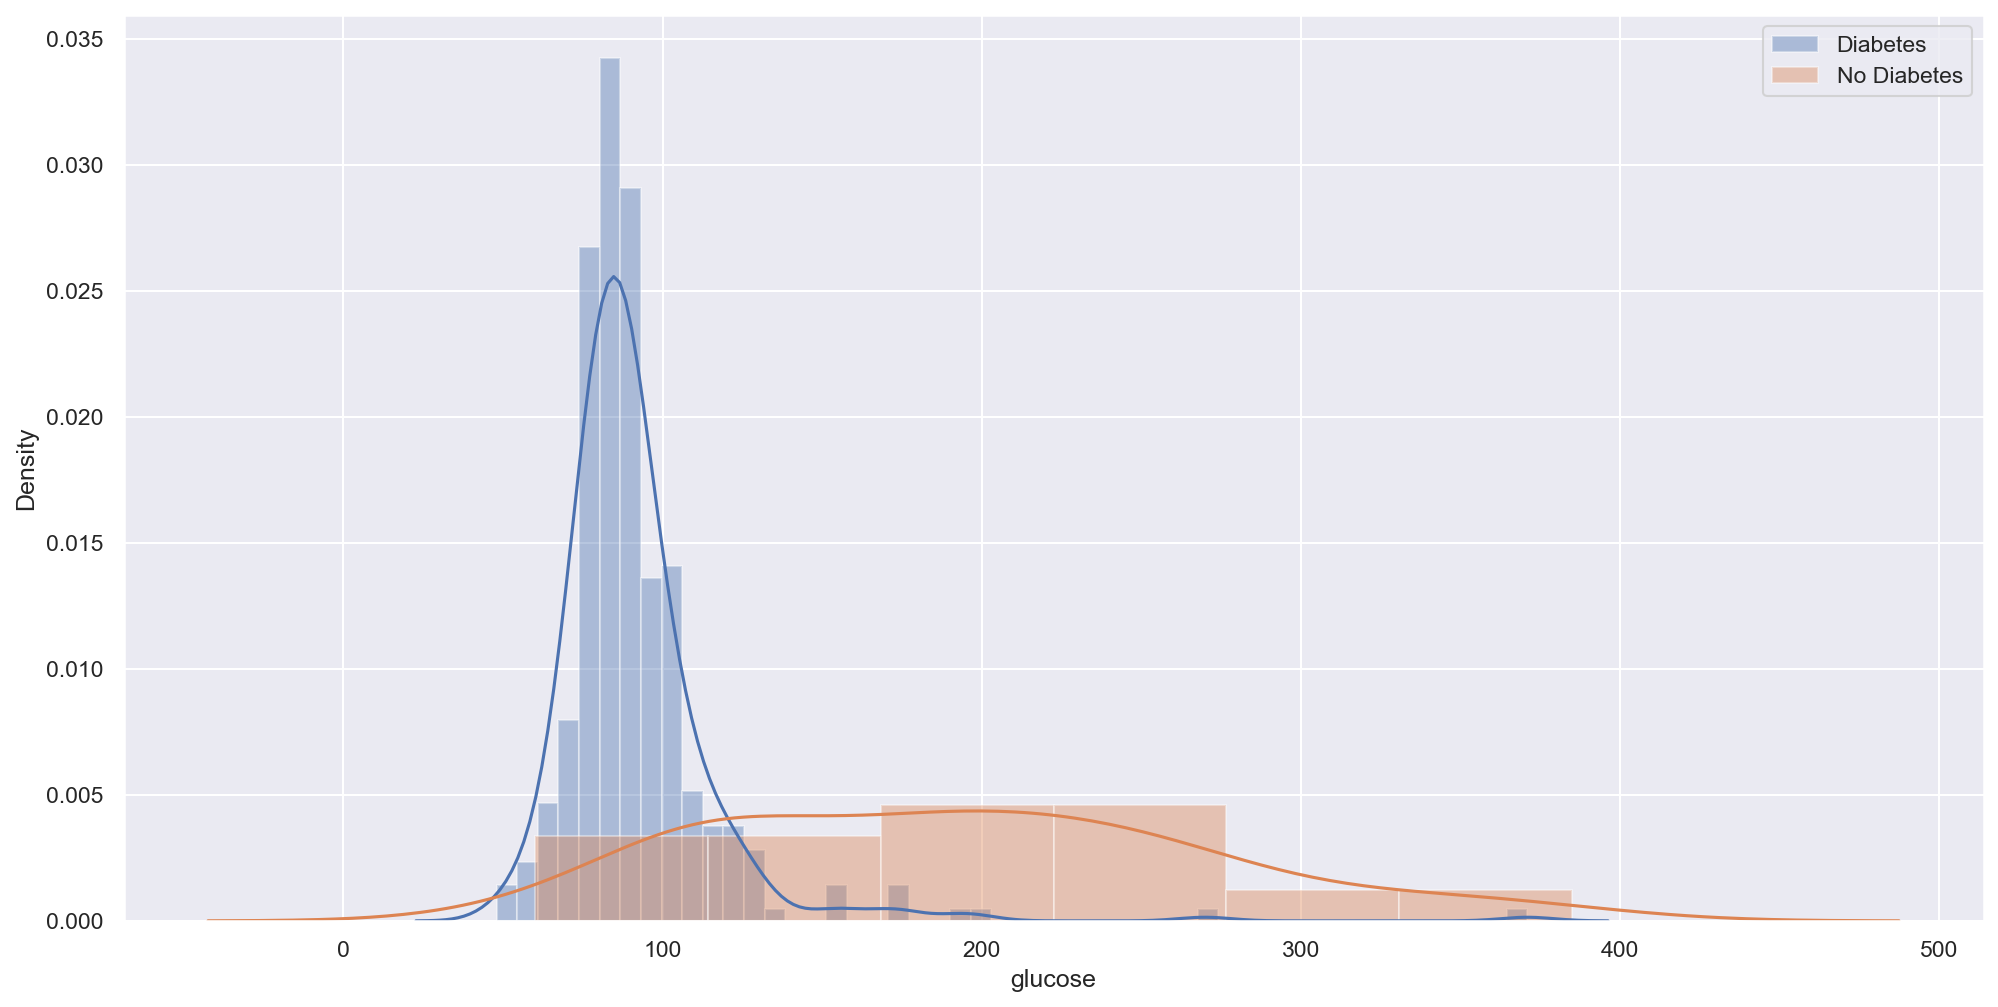

In [9]:
fig, ax = plt.subplots()
x = diabetes[diabetes['diabetes'] == False]['glucose']
y = diabetes[diabetes['diabetes'] == True]['glucose']

sns.distplot(x, ax=ax, kde=True, label = 'Diabetes')
sns.distplot(y, ax=ax, kde=True, label = 'No Diabetes')
ax.legend();

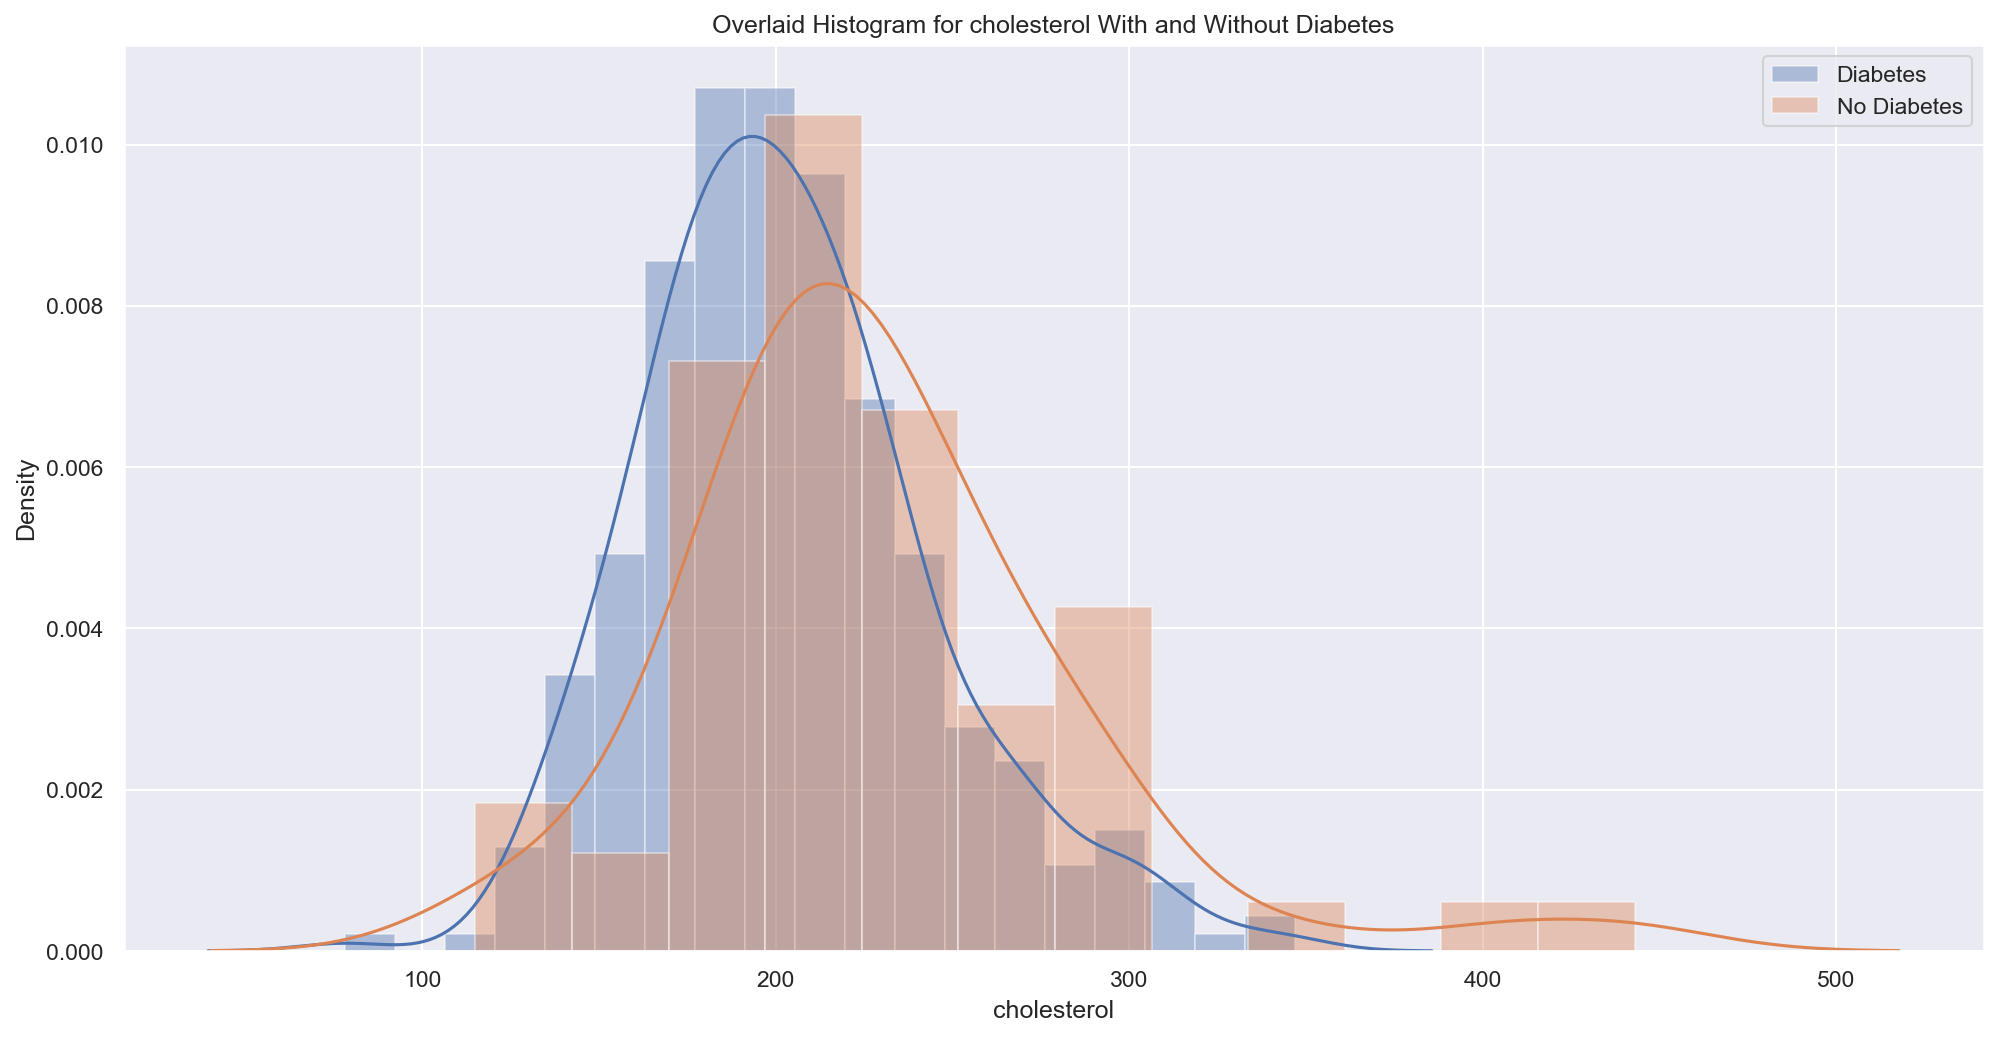

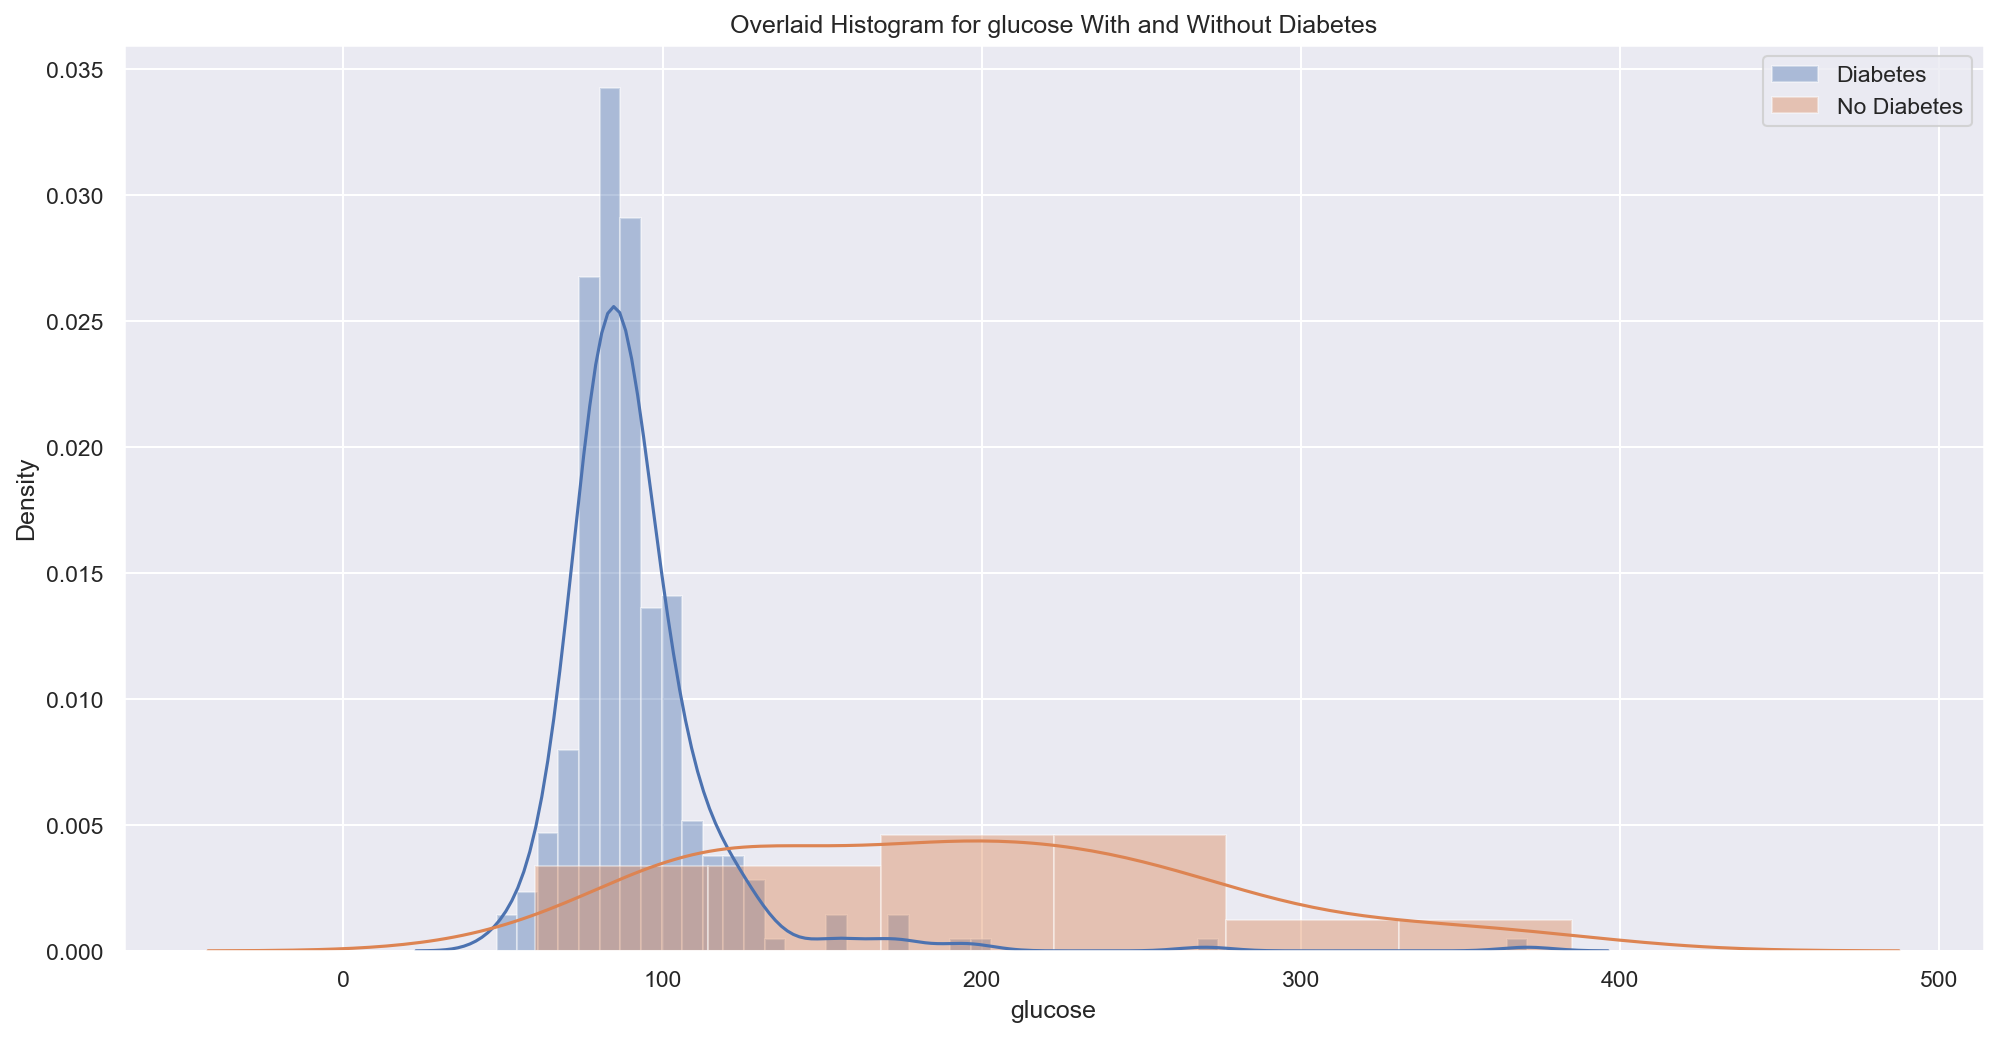

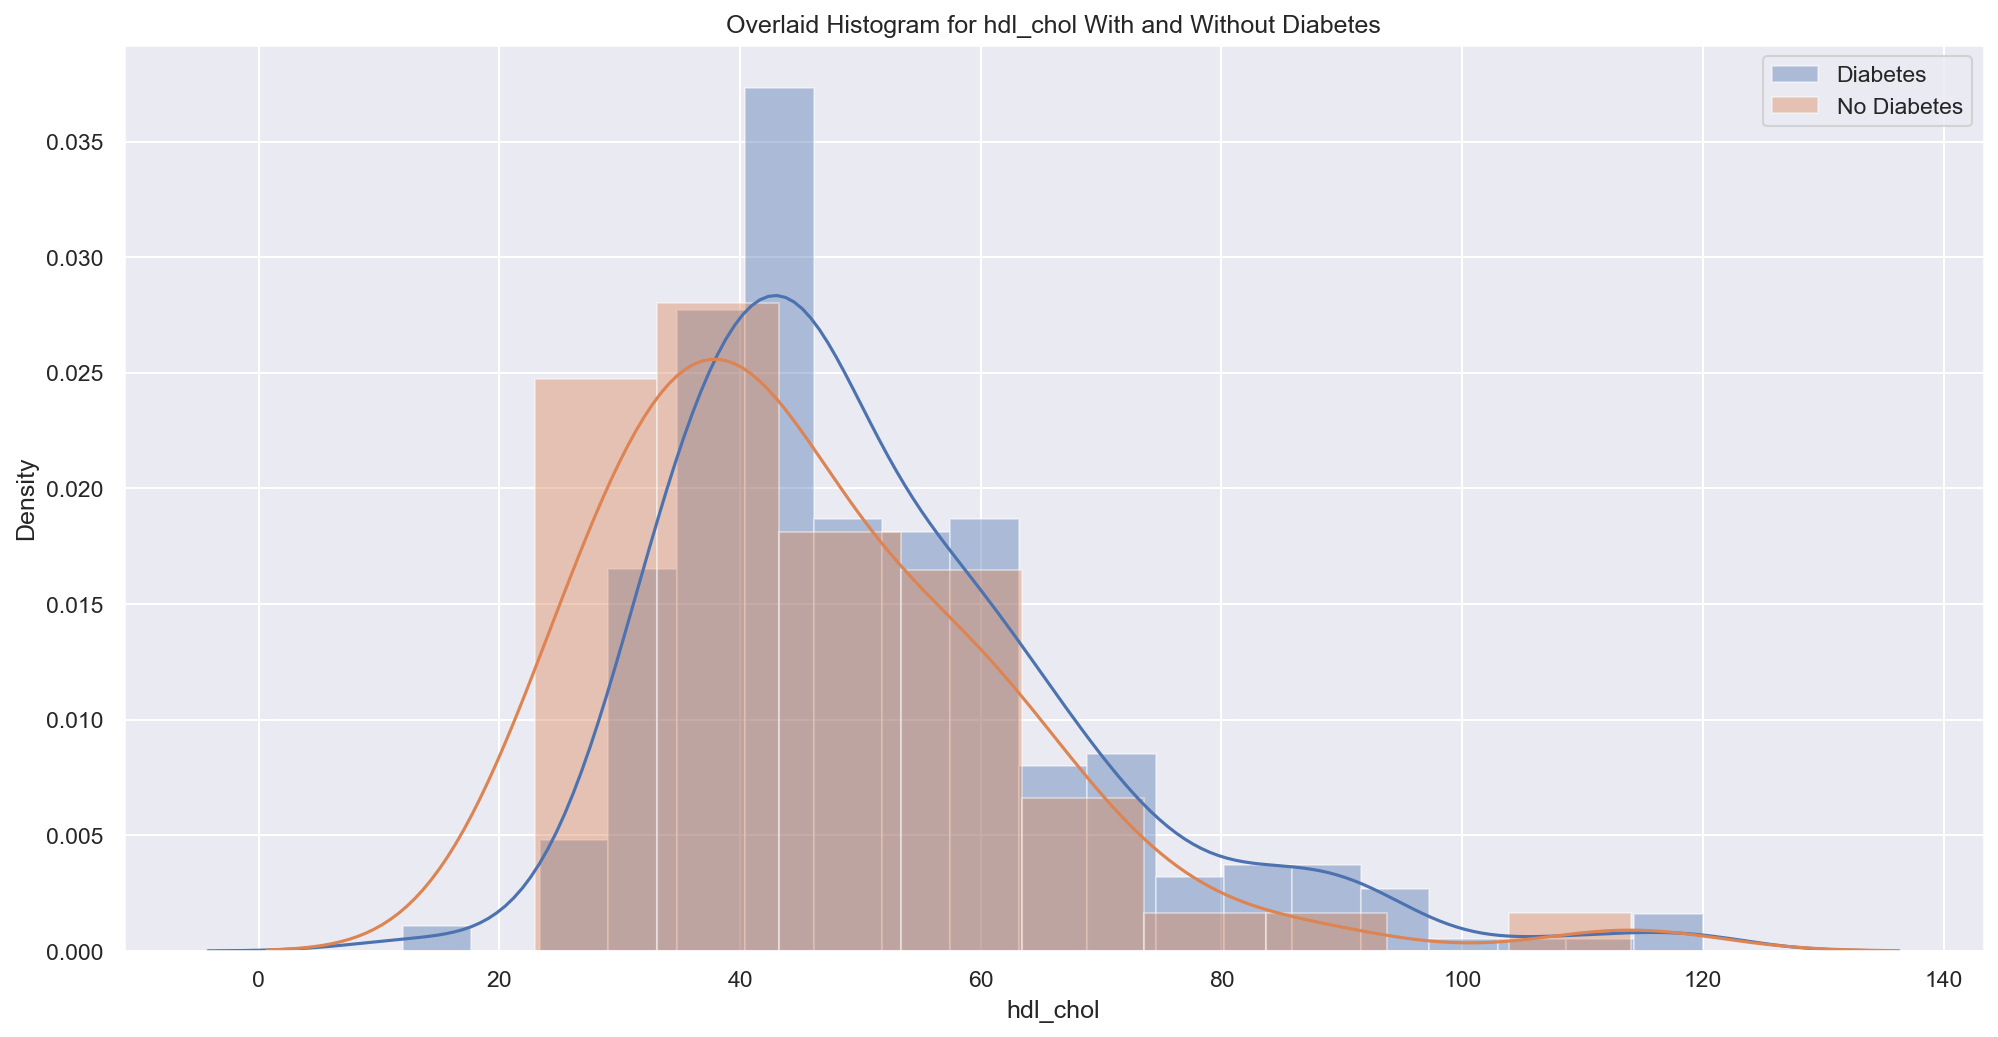

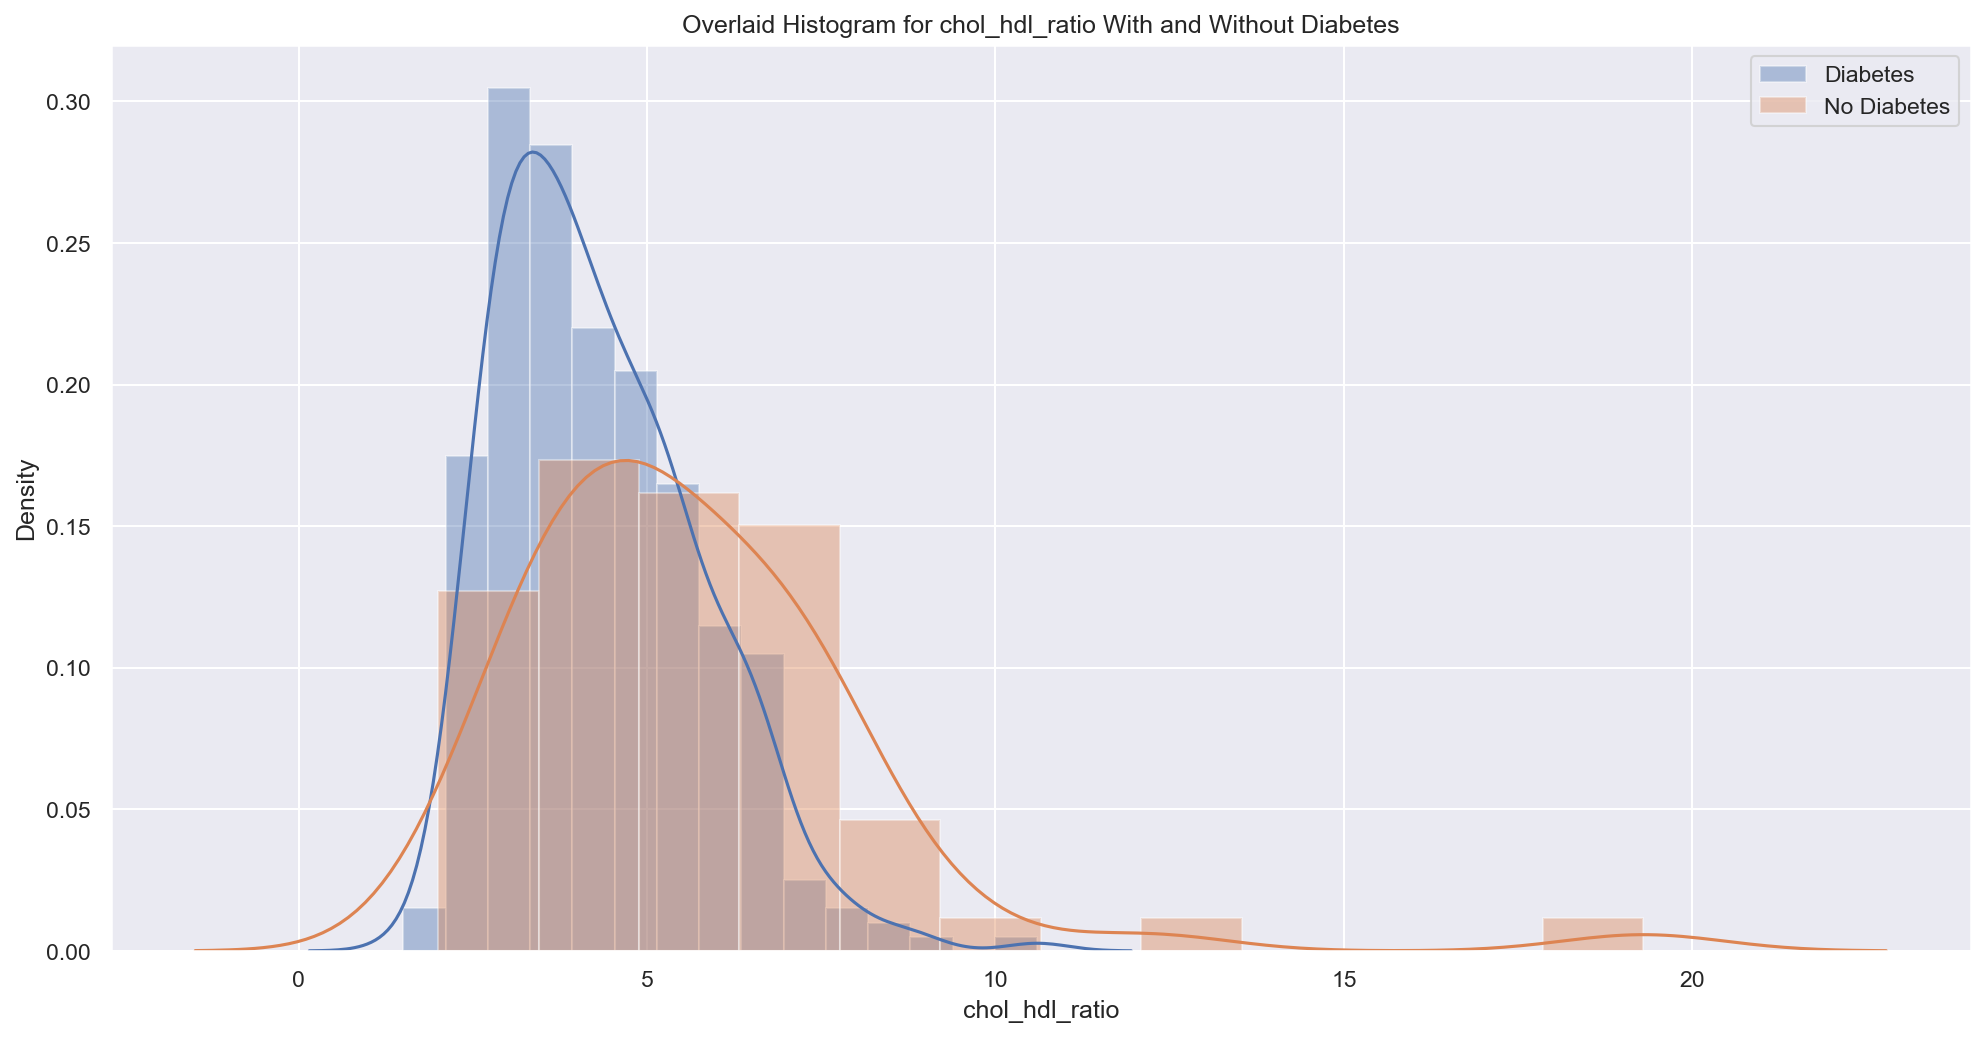

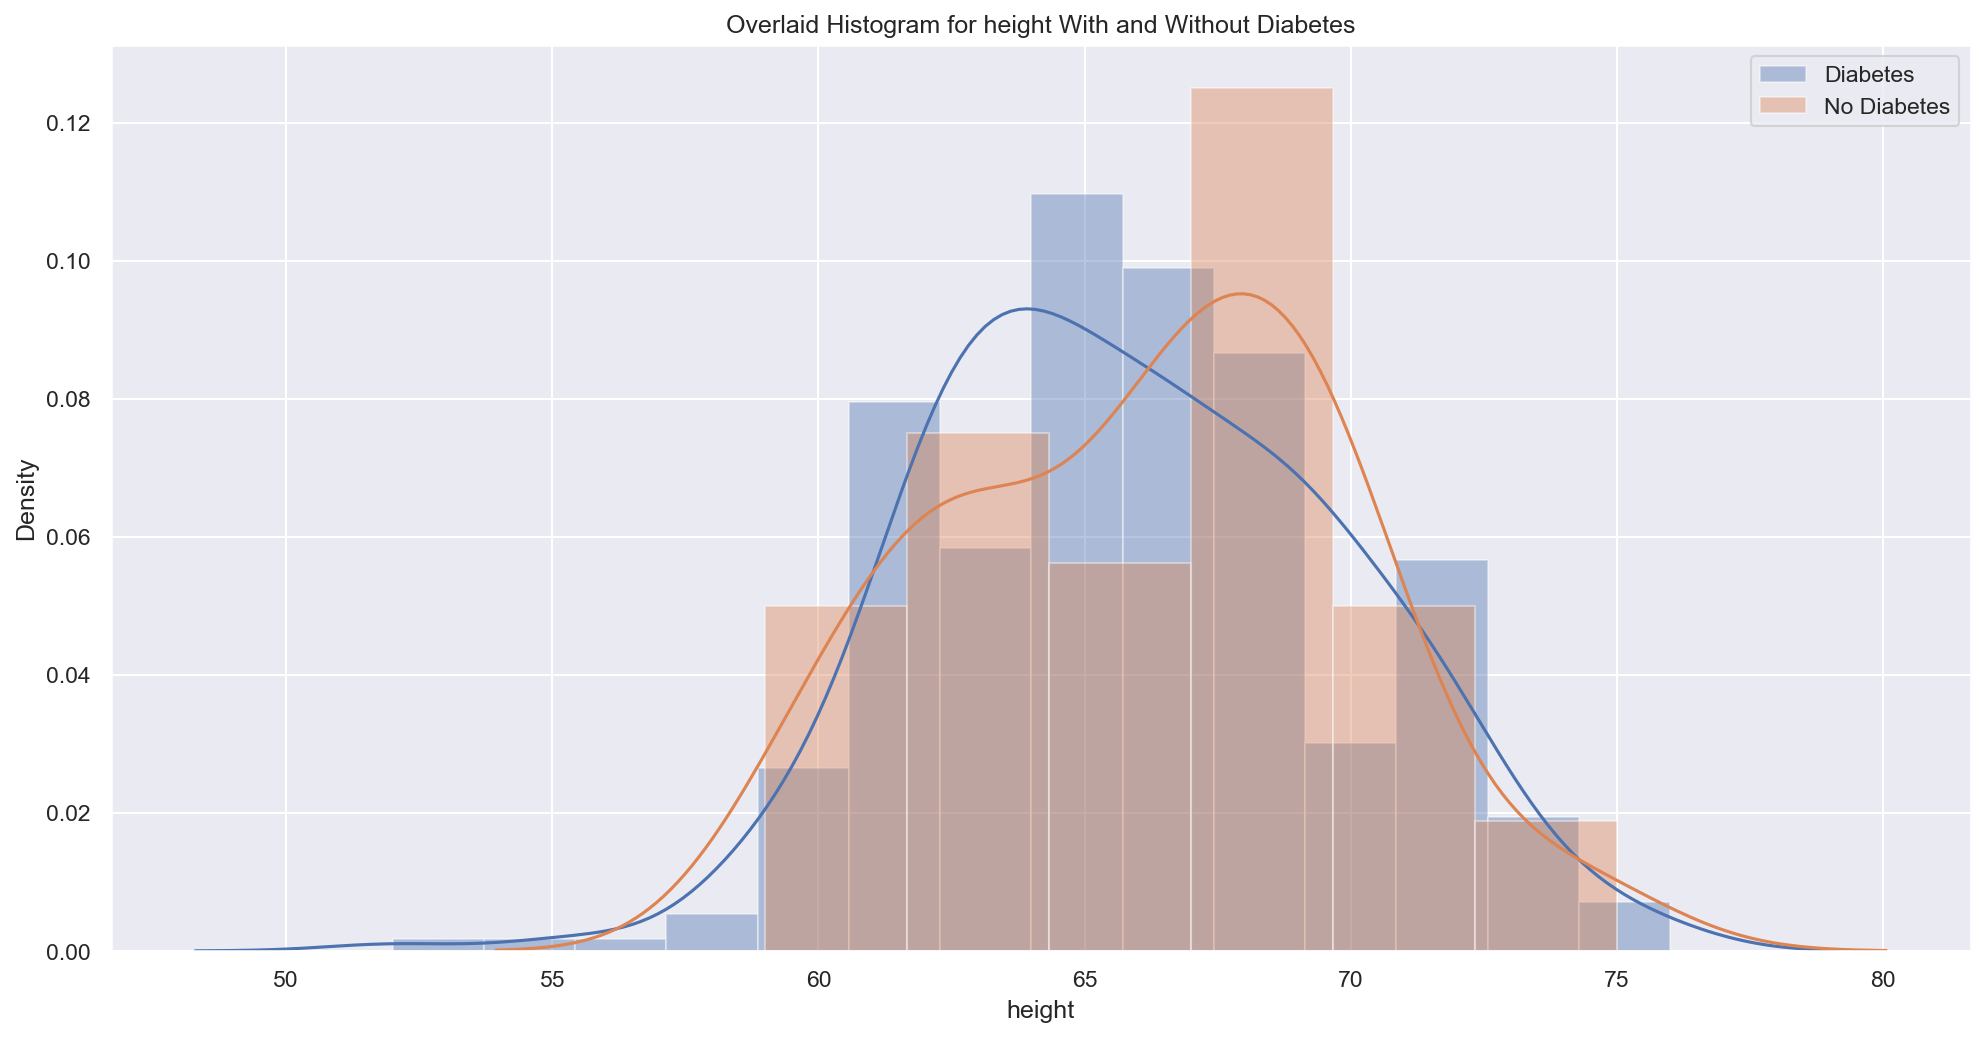

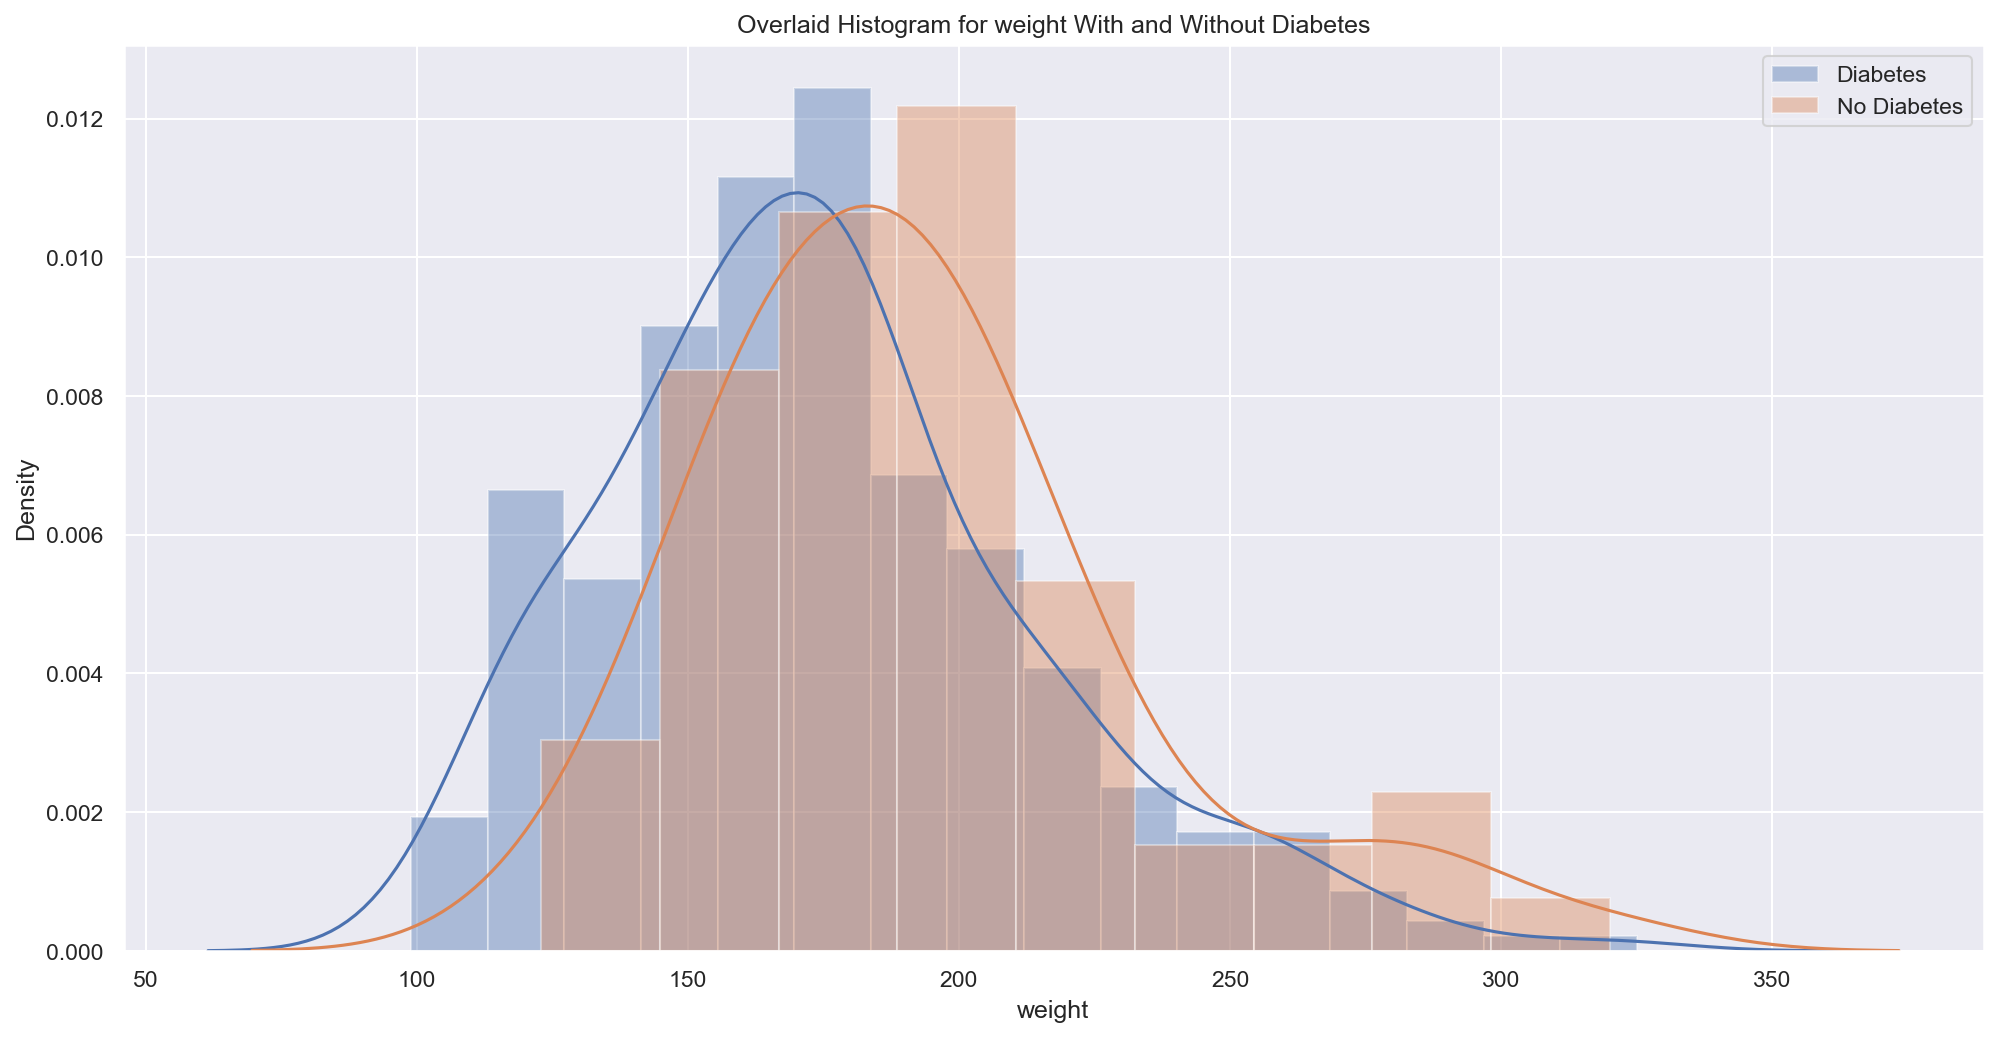

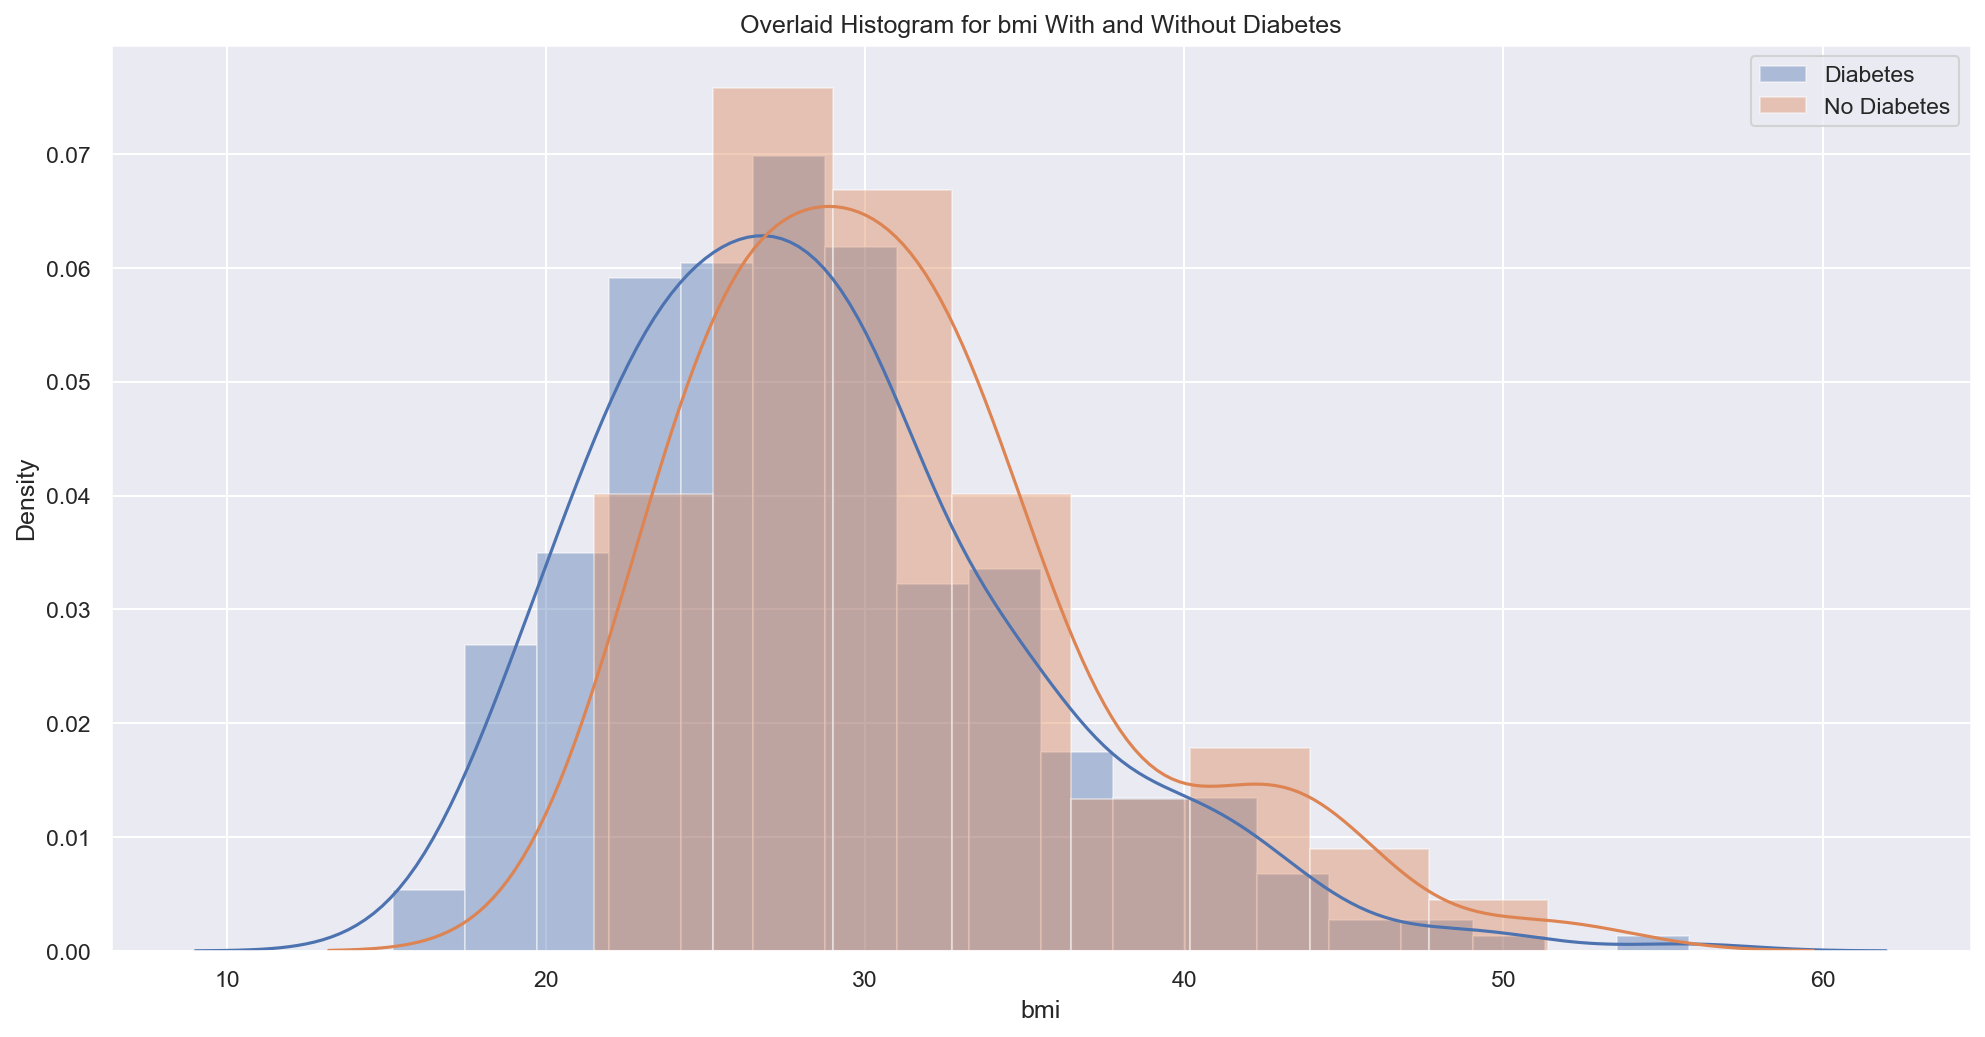

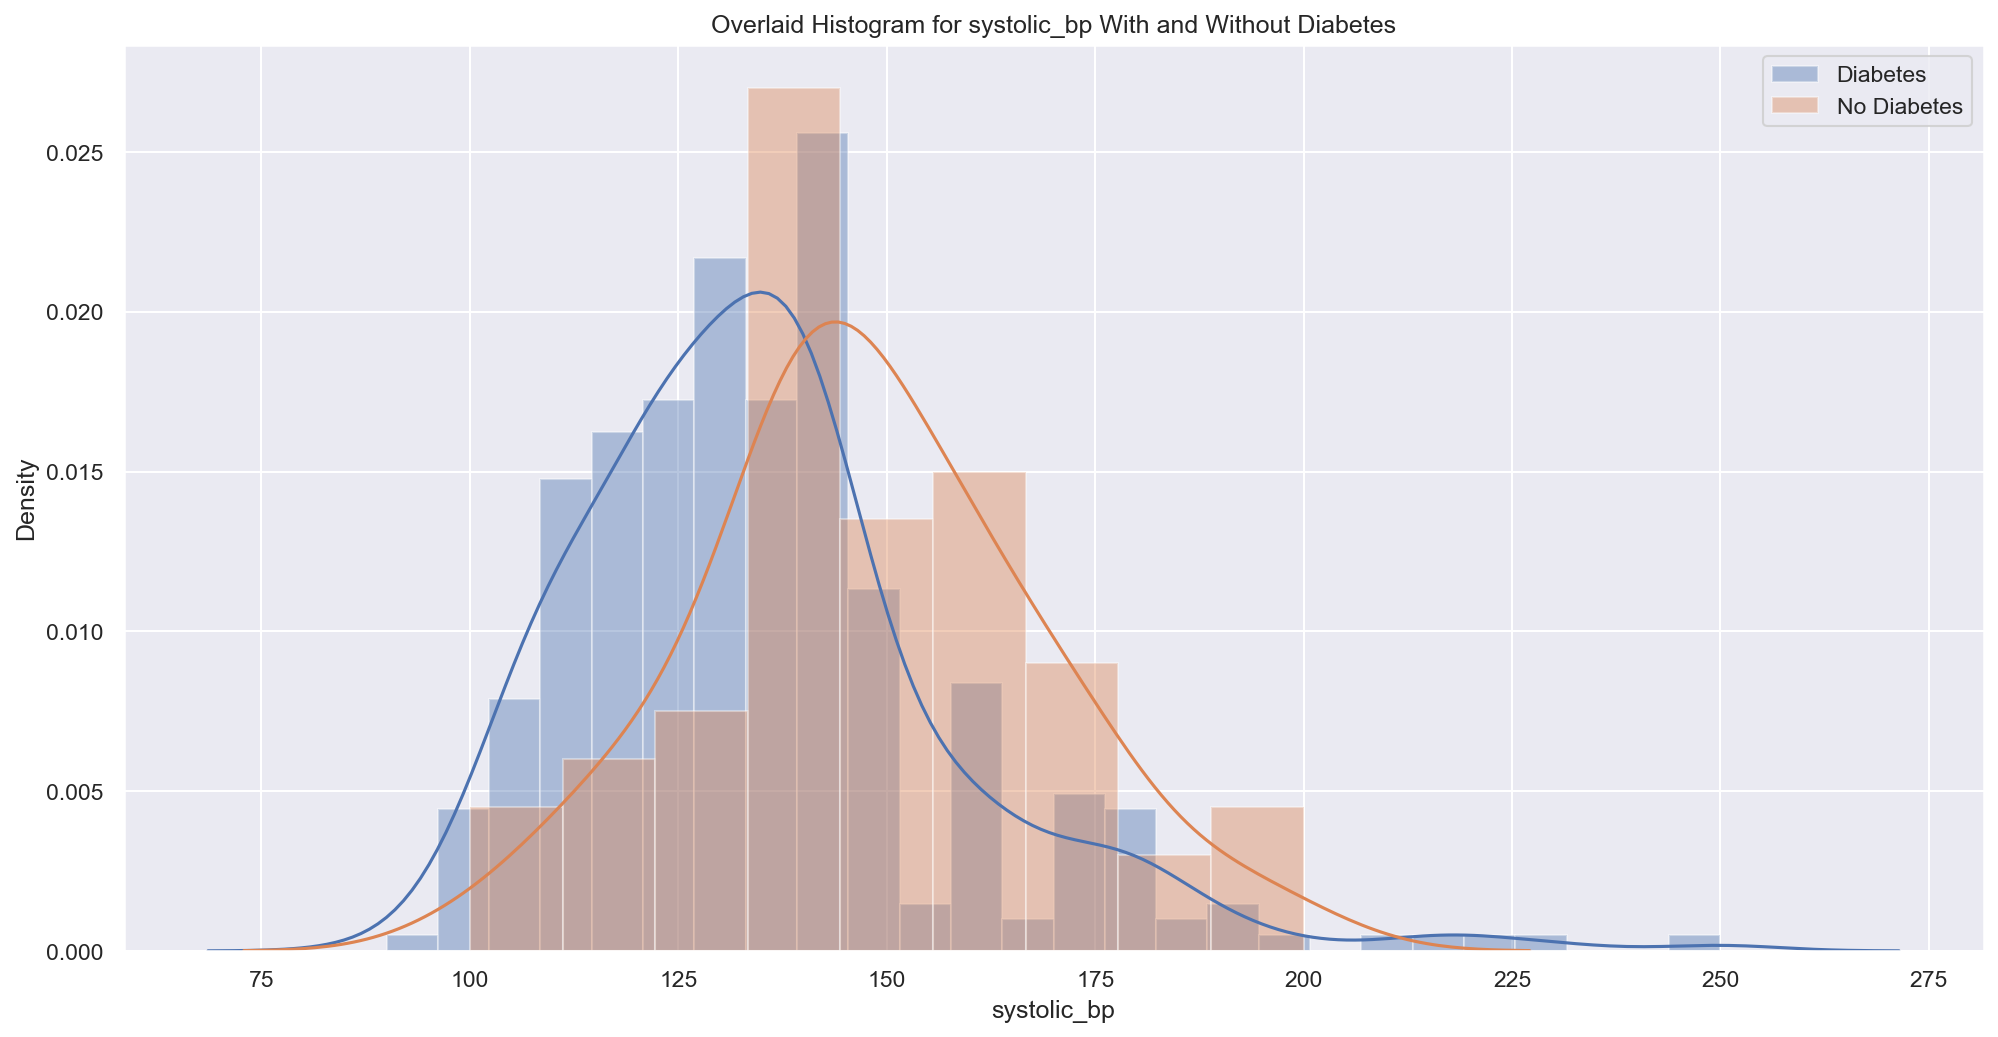

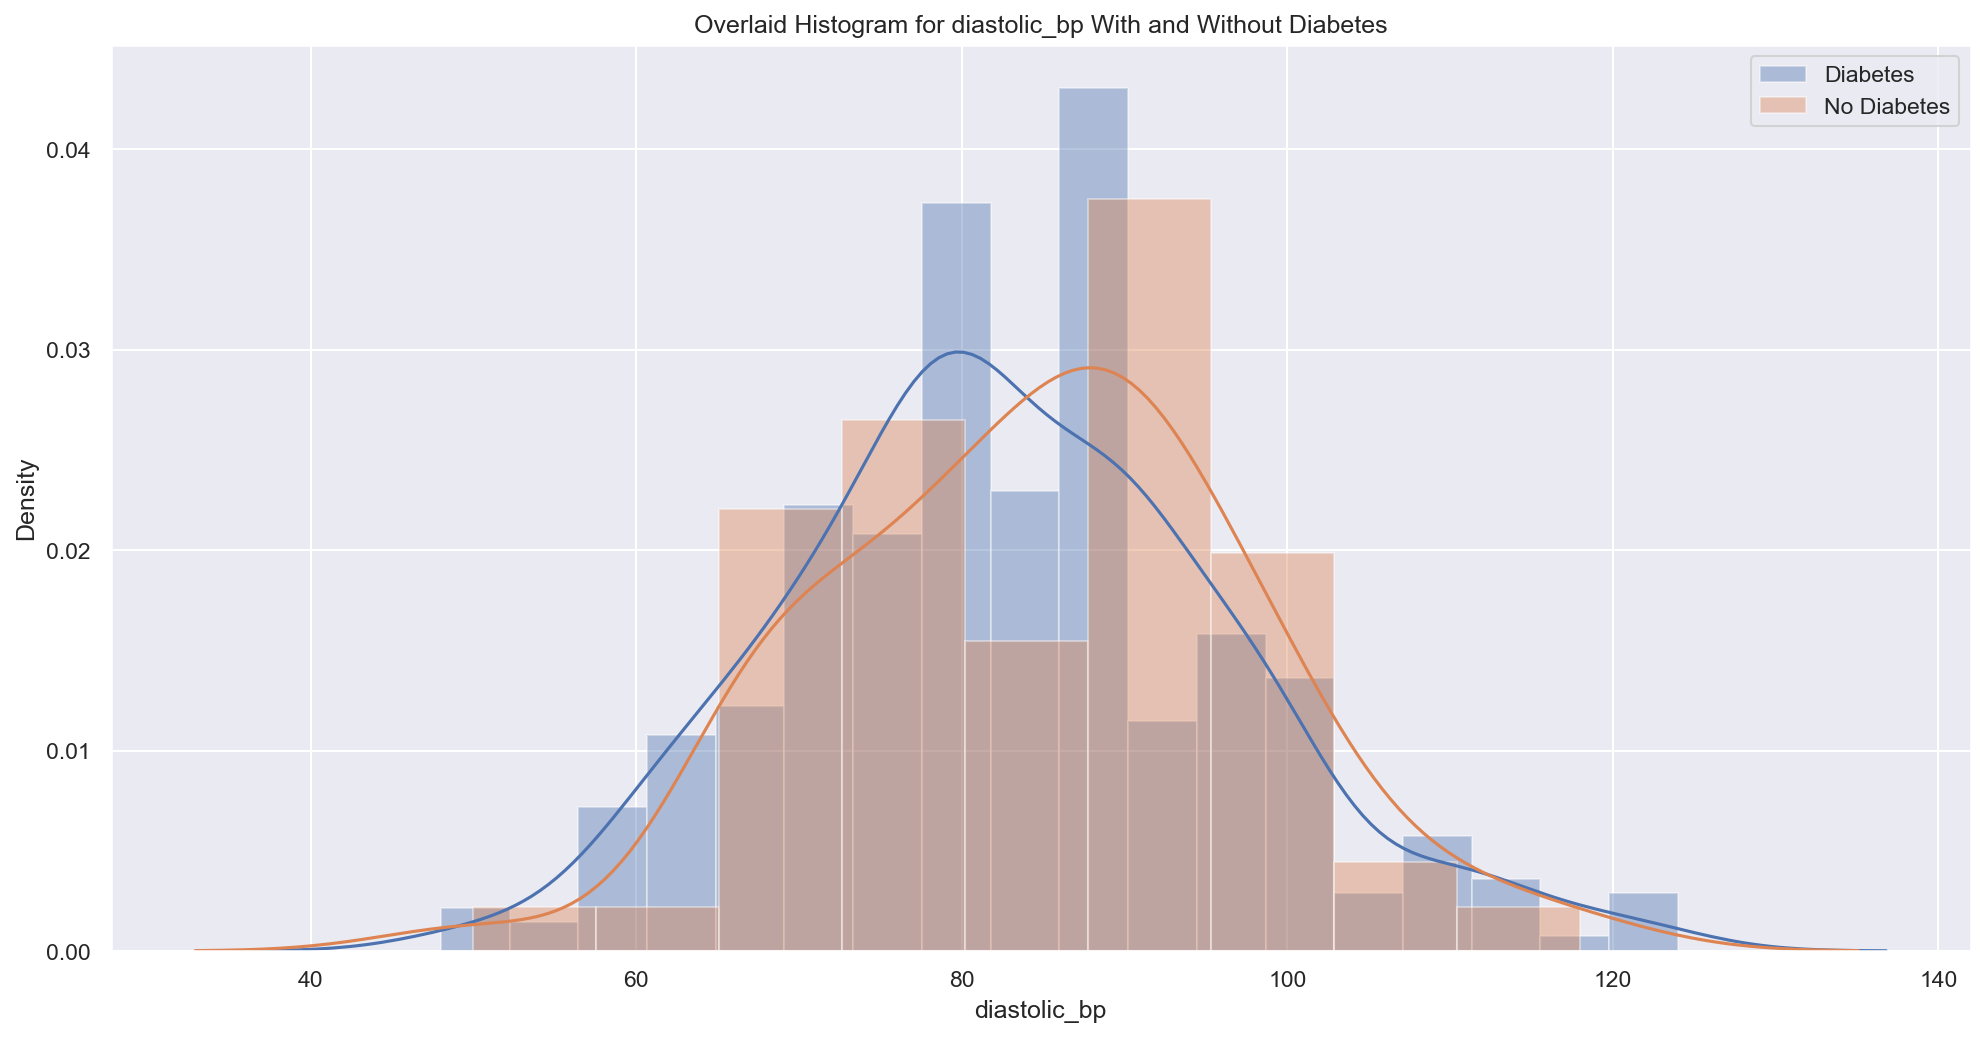

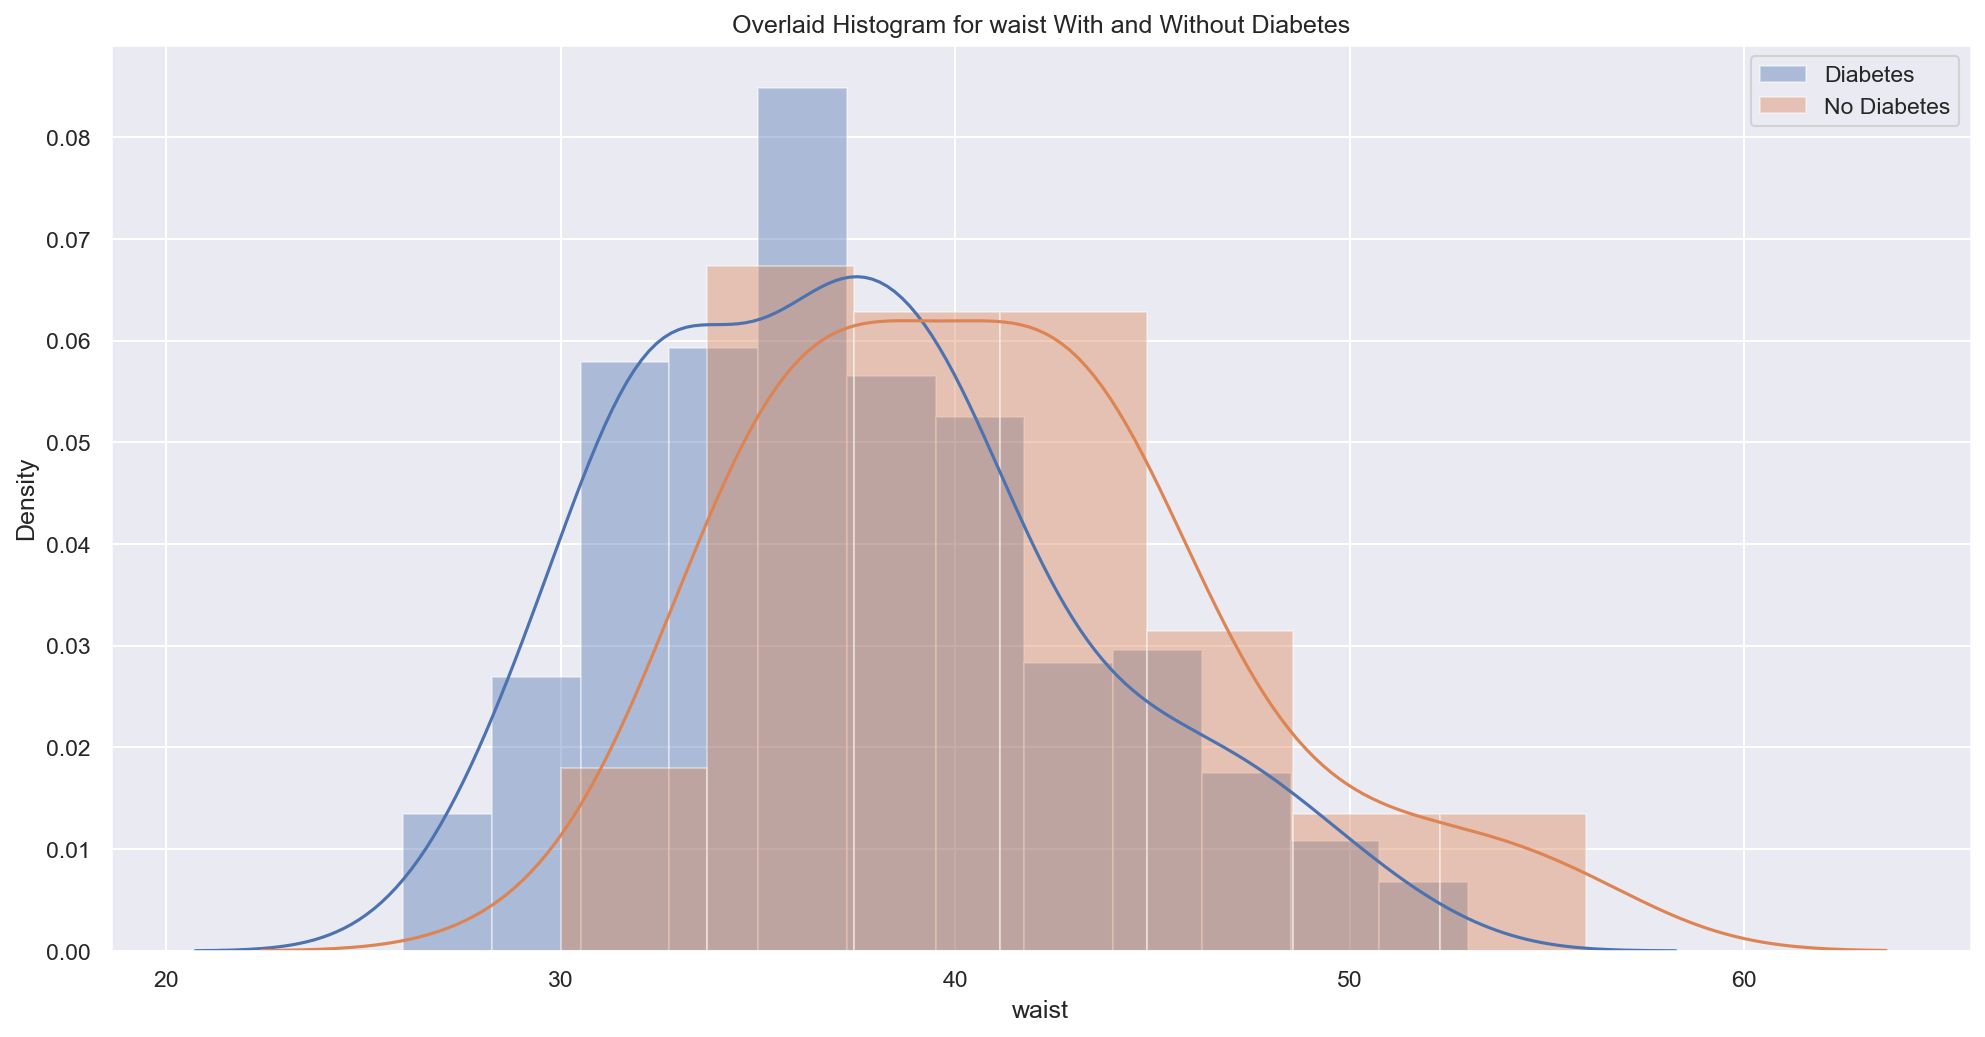

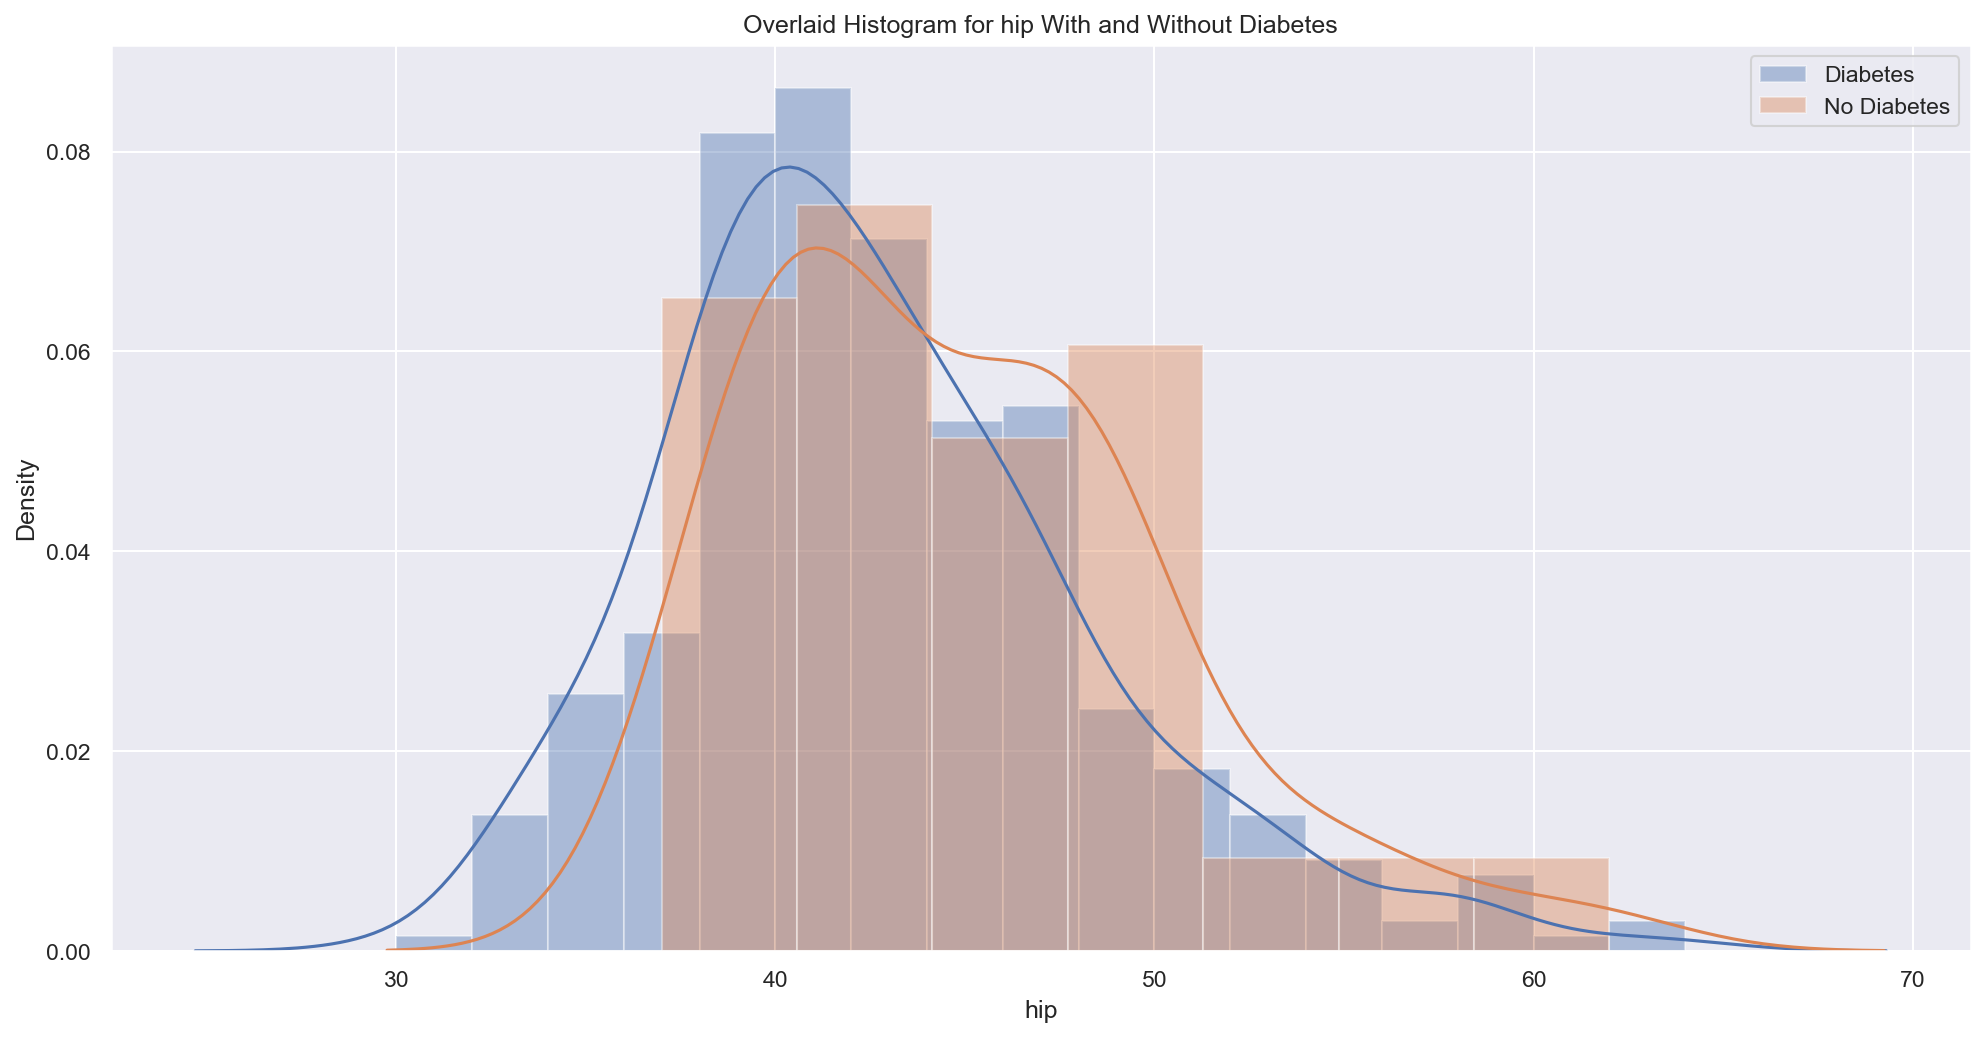

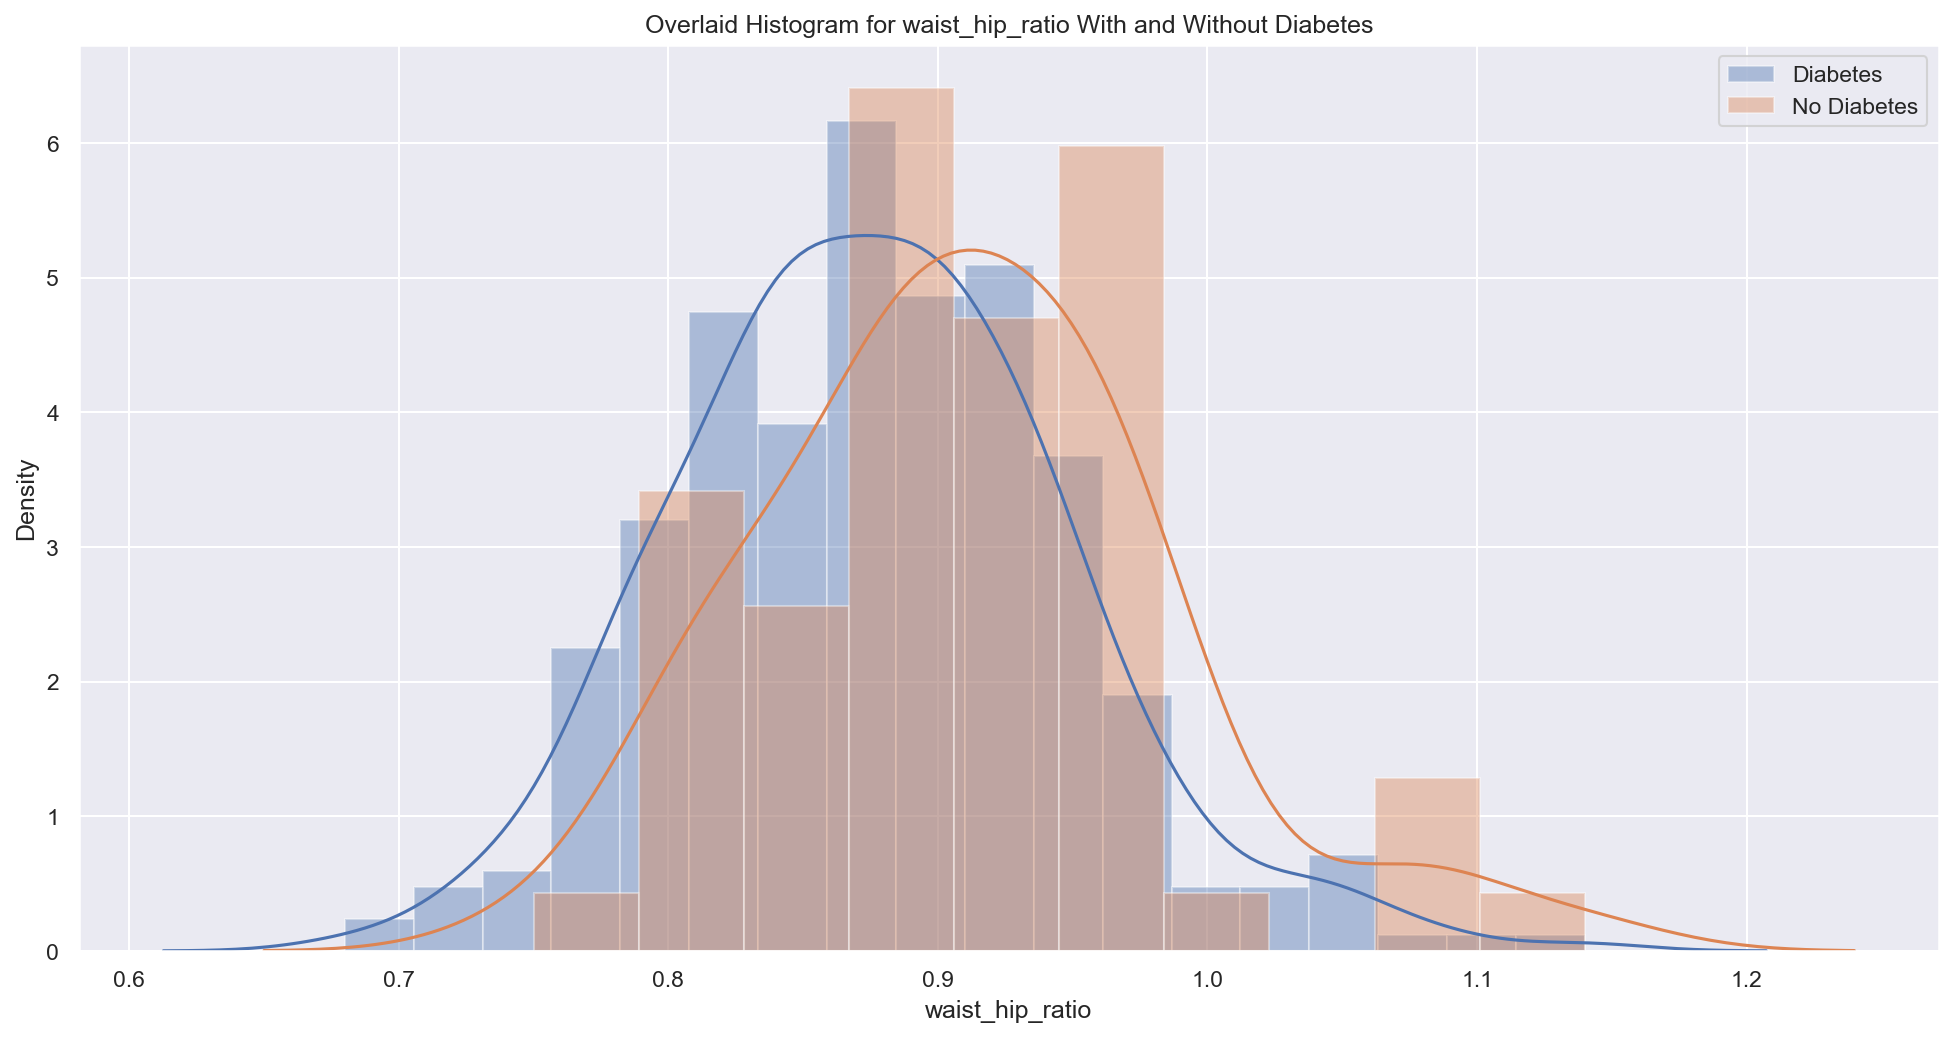

In [10]:
copy = diabetes.copy()
copy = copy.drop(['age', 'gender', 'diabetes'], axis = 1)
for col in copy.columns:
    fig, ax = plt.subplots()
    x1 = diabetes[diabetes['diabetes'] == False][col]
    y1 = diabetes[diabetes['diabetes'] == True][col]
    sns.distplot(x1, ax=ax, kde=True, label = 'Diabetes')
    sns.distplot(y1, ax=ax, kde=True, label = 'No Diabetes')
    plt.title('Overlaid Histogram for ' + col + ' With and Without Diabetes')
    ax.legend()

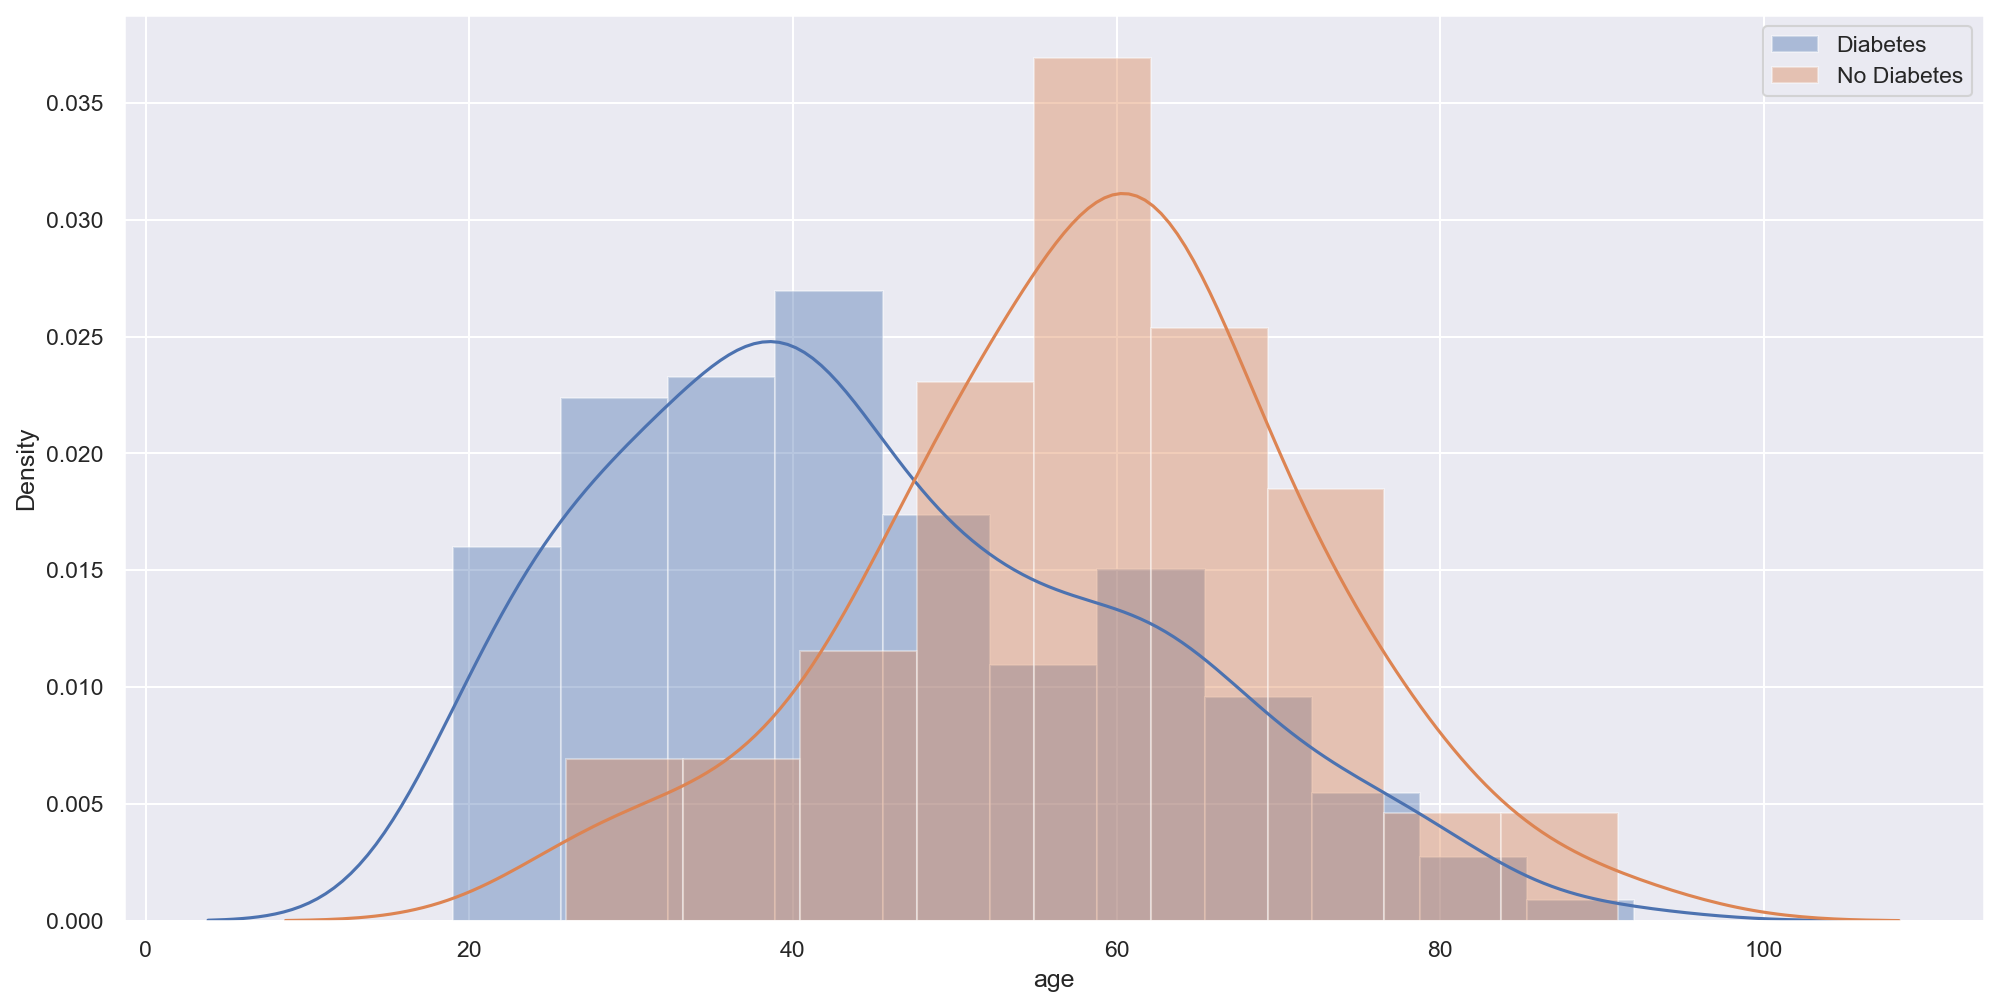

In [11]:
fig, ax = plt.subplots()
x = diabetes[diabetes['diabetes'] == 0]['age']
y = diabetes[diabetes['diabetes'] == 1]['age']

sns.distplot(x, ax=ax, kde=True, label = 'Diabetes')
sns.distplot(y, ax=ax, kde=True, label = 'No Diabetes')
ax.legend();

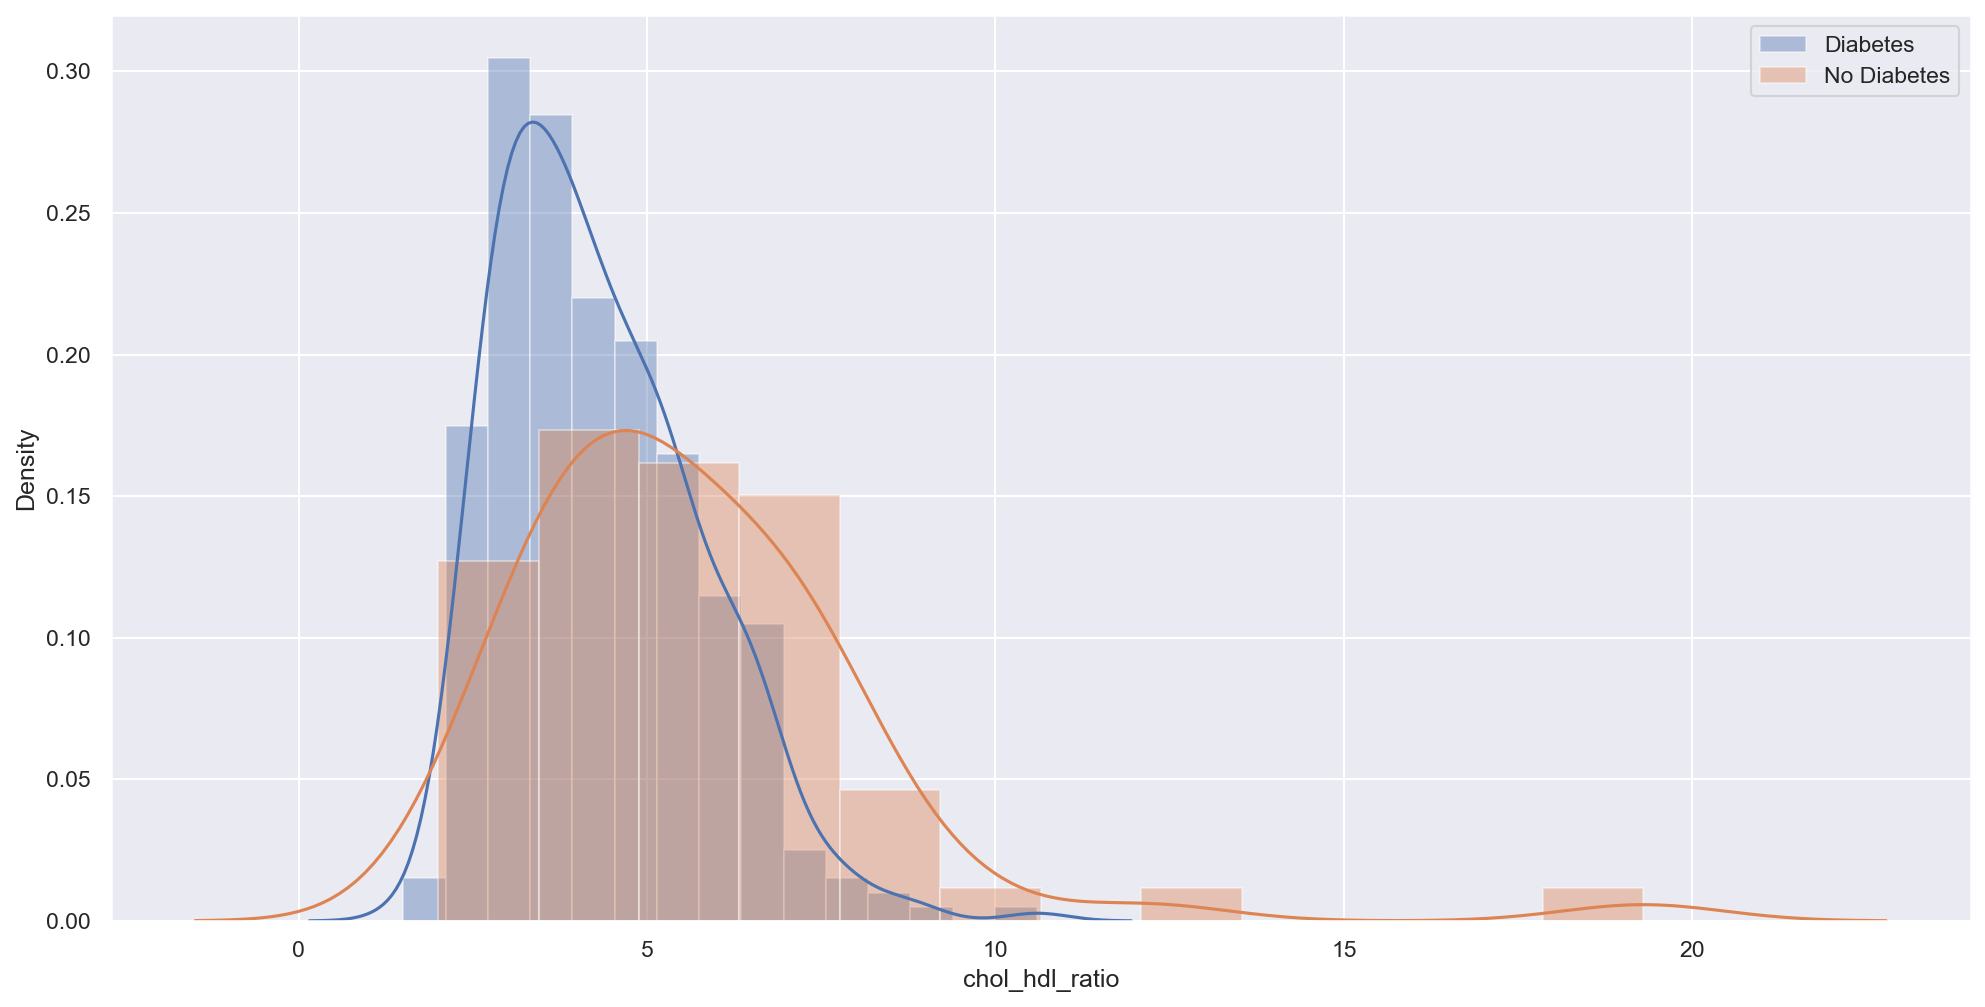

In [12]:
fig, ax = plt.subplots()
x = diabetes[diabetes['diabetes'] == 0]['chol_hdl_ratio']
y = diabetes[diabetes['diabetes'] == 1]['chol_hdl_ratio']

sns.distplot(x, ax=ax, kde=True, label = 'Diabetes')
sns.distplot(y, ax=ax, kde=True, label = 'No Diabetes')
ax.legend();

Outliers seem to be affecting the chol_hdl_ratio correlation.

## Test/Train Split

In [13]:
print('Before imputation:')
print(diabetes.isnull().sum())

Before imputation:
cholesterol        0
glucose            0
hdl_chol           0
chol_hdl_ratio     0
age                0
gender             0
height             0
weight             0
bmi                0
systolic_bp        0
diastolic_bp       0
waist              0
hip                0
waist_hip_ratio    0
diabetes           0
dtype: int64


In [14]:
diabetes.shape

(390, 15)

In [15]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(diabetes, test_size = 0.15, random_state = 42)

In [16]:
train = train.reset_index(drop = True)
val = val.reset_index(drop = True)
train.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,228,66,45,5.1,24,0,61,113,21.3,100,70,33,38,0.87,0
1,162,76,40,4.1,43,1,67,216,33.8,100,70,41,44,0.93,0
2,249,197,44,5.7,64,0,63,159,28.2,151,85,33,41,0.80,1
3,249,90,28,8.9,64,1,68,183,27.8,138,80,44,41,1.07,1
4,242,297,34,7.1,53,1,69,216,31.9,142,96,43,45,0.96,1


In [44]:
X_train = train[['systolic_bp', 'glucose', 'bmi', 'age', 'cholesterol', 'gender']]
Y_train = train['diabetes']

## Cross Validation

In [45]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel = 'linear', C = 1, random_state = 42)
scores = cross_val_score(clf, X_train, Y_train, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" %(scores.mean(), scores.std()))

0.93 accuracy with a standard deviation of 0.02


In [46]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
lasso = linear_model.Lasso()
y_pred = cross_val_predict(lasso, diabetes, diabetes['diabetes'], cv=3)

## Training Test

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9274924471299094


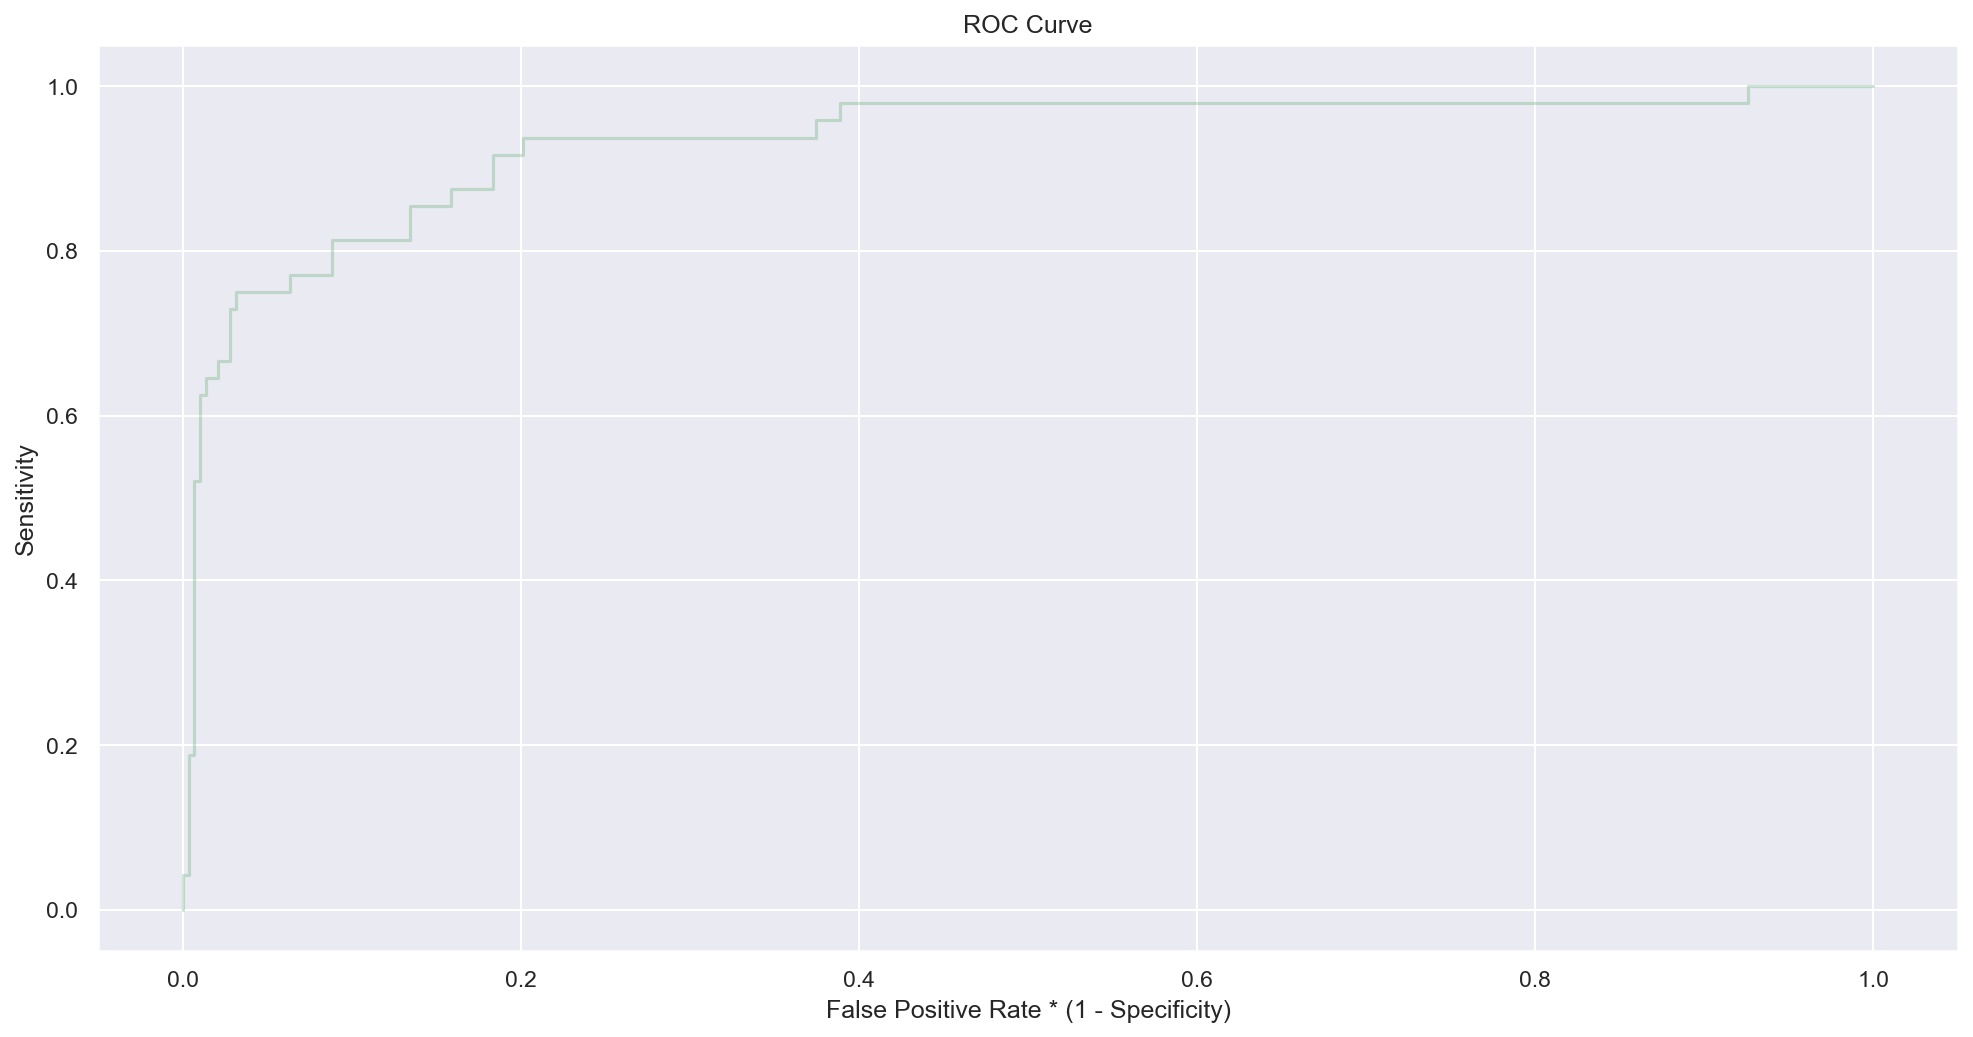

In [49]:
from sklearn.metrics import roc_curve
probs = model.predict_proba(X_train)[:, 1]
FP, sensitivity, thresholds = roc_curve(Y_train, probs, pos_label = 1)
plt.step(FP, sensitivity, color = 'g', alpha = .3, where = 'post')
plt.xlabel('False Positive Rate * (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('ROC Curve');

## Validation Test

In [50]:
X_val = val[['systolic_bp', 'glucose', 'bmi', 'age', 'cholesterol', 'gender']]
Y_val = val['diabetes']

In [51]:
val_model = LogisticRegression(solver = 'lbfgs')
val_model.fit(X_val, Y_val)

val_accuracy = val_model.score(X_val, Y_val)
print("Val Accuracy: ", val_accuracy)

Val Accuracy:  0.9322033898305084


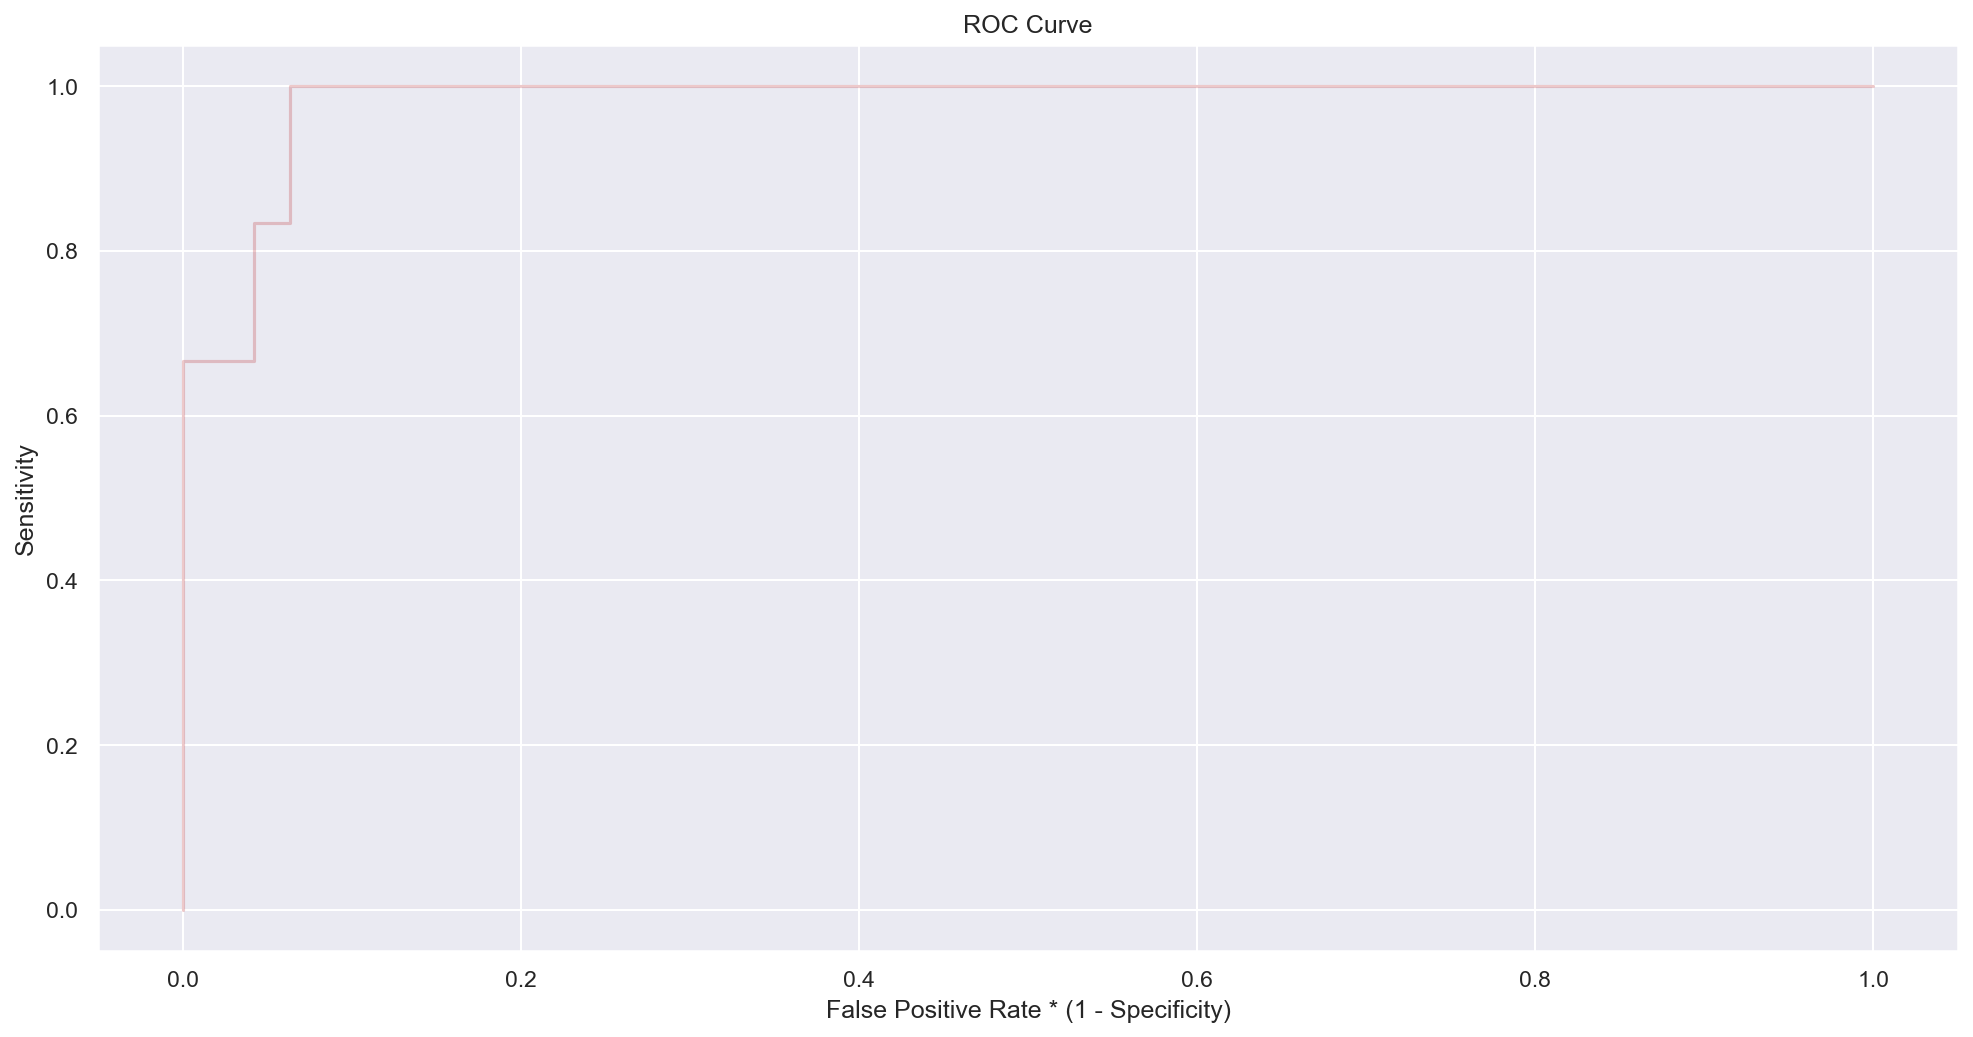

In [52]:
probs2 = val_model.predict_proba(X_val)[:, 1]
FP, sensitivity, thresholds = roc_curve(Y_val, probs2, pos_label = 1)
plt.step(FP, sensitivity, color = 'r', alpha = .3, where = 'post')
plt.xlabel('False Positive Rate * (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('ROC Curve');

## Conclusion
After analyzing and trying different models and features, I was able to attain a training and testing accuracy of around 93%. Cross validation was also performed during feature engineering to reduce the effect of overfitting the training data. In future work, I would like to obtain additional features such as race and type of diabetes in order to create a more applicable model to real life. This would provide more practical use as well as potential to increase the ability and accuracy of the model.